# Analysis of data for the paper: "Industry Support Analysis for Pricing-Driven DevOp in SaaS"
## Submitted to ICSOC 2024

### General variables, parameters, module imports, and functions required for the loading of the pricing models specified using Yaml4SaaS

> info: This notebook is a part of the supplementary material for the paper "Industry Support Analysis for Pricing-Driven DevOp in SaaS" submitted to ICSOC 2024. The notebook is used to analyze the pricing models specified using Yaml4SaaS. The notebook is written in Python and uses multiple libraries for data analysis and visualization. You must install the requirements specified in the `requirements.txt` file to run this notebook.

In [8]:
from scripts.PricingsLoader import PricingsLoader
from matplotlib import pyplot as plt
from scripts.models import PricingManager
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import os

BASE_PATH = os.path.abspath('')
FIGURES_PATH = os.path.join(BASE_PATH, 'figures')
DATA_PATH = os.path.join(BASE_PATH, 'data')

STUDIED_YEARS = ["2019", "2020", "2021", "2022", "2023", "2024"]

In [9]:
from math import comb

def calculate_subscriptions(pricing: PricingManager):
    
    np = len(pricing.plans)

    subscriptions = np

    add_ons_by_plan = {}

    for add_on in pricing.add_ons.values():
        for plan in add_on.available_for:
            add_ons_by_plan[plan] = add_ons_by_plan.get(plan, 0) + 1

    for plan, number_of_add_ons in add_ons_by_plan.items():
        for k in range(1, number_of_add_ons+1):
            subscriptions += comb(number_of_add_ons, k)
        
    return subscriptions

def get_data_from_dataset(dataset):
    data = {}
    max_plans = 0
    max_features = 0
    max_add_ons = 0

    for i in range(len(dataset)):
        pricing: PricingManager = dataset[i]
        saas_index_name = pricing.saas_name.split(" ")[0].strip().lower().capitalize()
        if saas_index_name.lower() == "office":
            continue
        if saas_index_name not in data:
            data[saas_index_name] = {year: None for year in STUDIED_YEARS}
        
        data[saas_index_name][str(pricing.year)] = {}
        data[saas_index_name][str(pricing.year)]["number_of_features"] = len(pricing.features)
        data[saas_index_name][str(pricing.year)]["number_of_plans"] = len(pricing.plans)
        data[saas_index_name][str(pricing.year)]["number_of_addons"] = len(pricing.add_ons)
        data[saas_index_name][str(pricing.year)]["has_many_products"] = len(pricing.saas_name.strip().split(" ")) > 1
        data[saas_index_name][str(pricing.year)]["size_of_configuration_space"] = calculate_subscriptions(pricing)

        if len(pricing.features) > max_features:
            max_features = len(pricing.features)
        
        if len(pricing.plans) > max_plans:
            max_plans = len(pricing.plans)
        
        if len(pricing.add_ons) > max_add_ons:
            max_add_ons = len(pricing.add_ons)

    data_items = sorted(data.items(), key=lambda x: x[0], reverse=True)
    data = dict(data_items)

    return data, max_plans, max_features, max_add_ons

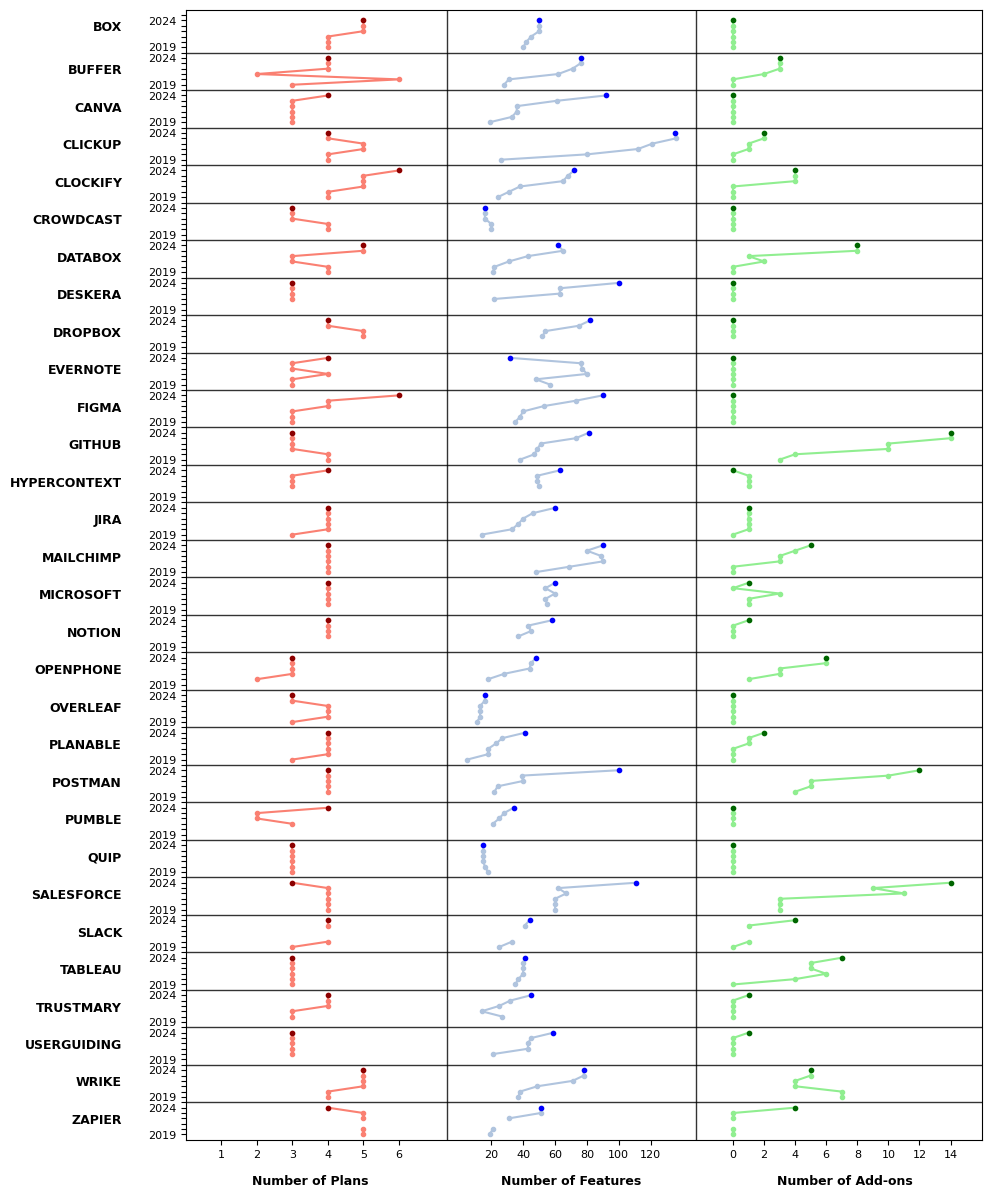

In [10]:
METRICS = ["Number of Plans", "Number of Features", "Number of Add-ons"]
GROUP_SIZE = len(STUDIED_YEARS)+1
X_SEPARATION = 10
FIG_HEIGHT = 12
X_AXIS_WIDTH = 300

TAGS_INTERVAL_PLANS = 1
TAGS_INTERVAL_FEATURES = 20
TAGS_INTERVAL_ADD_ONS = 2

RECTANGLE_WIDTH = X_AXIS_WIDTH//(len(METRICS))

def format_data_for_visualization(data, max_plans, max_features, max_add_ons):
    formatted_data = {}
    data_items = list(data.items())
    
    for i in range(len(data)):
        start_y_pos = i*GROUP_SIZE
        end_y_pos = start_y_pos + GROUP_SIZE - 1
        saas = data_items[i][0]
        saas_details = data_items[i][1]
        formatted_data[saas] = {'plans': {'x': [], 'y': []}, 'features': {'x': [], 'y': []}, 'add_ons': {'x': [], 'y': []}}

        for j in range(start_y_pos, end_y_pos):
            iter_index = j - start_y_pos
            year = STUDIED_YEARS[iter_index]
            year_data = saas_details[year]
            number_of_plans = None
            number_of_features = None
            number_of_add_ons = None

            if year_data is not None:
                number_of_plans = RECTANGLE_WIDTH/(max_plans + TAGS_INTERVAL_PLANS) * year_data['number_of_plans']
                number_of_features =  RECTANGLE_WIDTH + X_SEPARATION + RECTANGLE_WIDTH/(max_features + TAGS_INTERVAL_FEATURES) * year_data['number_of_features']
                number_of_add_ons = 2*RECTANGLE_WIDTH + 2*X_SEPARATION + RECTANGLE_WIDTH/(max_add_ons + TAGS_INTERVAL_ADD_ONS) * year_data['number_of_addons']

            formatted_data[saas]['plans']['x'].append(number_of_plans)
            formatted_data[saas]['features']['x'].append(number_of_features)
            formatted_data[saas]['add_ons']['x'].append(number_of_add_ons)
            formatted_data[saas]['plans']['y'].append(j)
            formatted_data[saas]['features']['y'].append(j)
            formatted_data[saas]['add_ons']['y'].append(j)
    
    return formatted_data

def generate_figure(dataset):

    data, max_plans, max_features, max_add_ons = get_data_from_dataset(dataset)

    formatted_data = format_data_for_visualization(data, max_plans, max_features, max_add_ons)

    ds_size = len(data)

    x_plans_ticks = list(np.arange(0, RECTANGLE_WIDTH+1, TAGS_INTERVAL_PLANS*RECTANGLE_WIDTH/(max_plans + TAGS_INTERVAL_PLANS)))[1:-1]
    x_features_ticks = list(np.arange(RECTANGLE_WIDTH+X_SEPARATION, 2*RECTANGLE_WIDTH+X_SEPARATION+1, TAGS_INTERVAL_FEATURES*RECTANGLE_WIDTH/(max_features + TAGS_INTERVAL_FEATURES)))[1:-1]
    x_add_ons_ticks = list(np.arange(2*RECTANGLE_WIDTH+2*X_SEPARATION, 3*RECTANGLE_WIDTH+2*X_SEPARATION+1, TAGS_INTERVAL_ADD_ONS*RECTANGLE_WIDTH/(max_add_ons + TAGS_INTERVAL_ADD_ONS)))[:-1]

    x_plans_tags = [i for i in range(1, max_plans + 1, TAGS_INTERVAL_PLANS)]
    x_features_tags = [i for i in range(TAGS_INTERVAL_FEATURES, max_features + 1, TAGS_INTERVAL_FEATURES)]
    x_add_ons_tags = [i for i in range(0, max_add_ons + 1, TAGS_INTERVAL_ADD_ONS)]

    x_ticks = x_plans_ticks + x_features_ticks + x_add_ons_ticks
    x_tags = x_plans_tags + x_features_tags + x_add_ons_tags
    y_range = range(ds_size*7)
    y_tags = ([STUDIED_YEARS[0]] + ["  "]*(len(STUDIED_YEARS)-2) + [STUDIED_YEARS[-1]] + ["  "])*ds_size

    fig, ax = plt.subplots(figsize=(10, FIG_HEIGHT))

    for _, values in formatted_data.items():
        ax.plot(values['plans']['x'], values['plans']['y'], marker='o', linestyle='-', color='salmon', markersize=3)
        ax.plot(values['features']['x'], values['features']['y'], marker='o', linestyle='-', color='lightsteelblue', markersize=3)
        ax.plot(values['add_ons']['x'], values['add_ons']['y'], marker='o', linestyle='-', color='lightgreen', markersize=3)
        
        filtered_plans_x = list(filter(lambda x: x is not None, values['plans']['x']))
        filtered_plans_y = list(filter(lambda y: y is not None, values['plans']['y']))
        filtered_features_x = list(filter(lambda x: x is not None, values['features']['x']))
        filtered_features_y = list(filter(lambda y: y is not None, values['features']['y']))
        filtered_add_ons_x = list(filter(lambda x: x is not None, values['add_ons']['x']))
        filtered_add_ons_y = list(filter(lambda y: y is not None, values['add_ons']['y']))
        
        ax.plot(filtered_plans_x[-1], filtered_plans_y[-1], marker='o', linestyle='-', color='darkred', markersize=3)  
        ax.plot(filtered_features_x[-1], filtered_features_y[-1], marker='o', linestyle='-', color='blue', markersize=3)
        ax.plot(filtered_add_ons_x[-1], filtered_add_ons_y[-1], marker='o', linestyle='-', color='darkgreen', markersize=3)
    
    ax.set_xticks(x_ticks, labels=x_tags)
    ax.set_yticks(y_range, labels=y_tags)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    yticks = ax.get_yticks()

    for i in range(0, len(yticks), 7):

        if i + 7 < len(yticks):
            group_label_position = (yticks[i] + yticks[i + 4]) / 2
        else:
            group_label_position = (yticks[i] + yticks[-1]) / 2
        
        separator_position = yticks[i-1]

        ax.text(-0.08, group_label_position, list(map(lambda x: x.upper(), formatted_data.keys()))[i//7], transform=ax.get_yaxis_transform(),
                horizontalalignment='right', fontsize=9, fontweight='bold')
        
        if i > 0:
            ax.axhline(y=separator_position, color='black', linestyle='-', linewidth=1, alpha=0.8)
            
    for i in range(len(METRICS)):
    
        x_separation_start_coef = i - 1
    
        if x_separation_start_coef < 0:
            x_separation_start_coef = 0

        tag_position = (i*RECTANGLE_WIDTH + x_separation_start_coef*X_SEPARATION + (i+1)*RECTANGLE_WIDTH+i*X_SEPARATION) / 2
    
        ax.text(tag_position, -0.04, METRICS[i], transform=ax.get_xaxis_transform(),
                horizontalalignment='center', fontsize=9, fontweight='bold')

    ax.axvline(x=RECTANGLE_WIDTH + X_SEPARATION/2, color='black', linestyle='-', linewidth=1, alpha=0.8)
    ax.axvline(x=2*RECTANGLE_WIDTH + X_SEPARATION/2, color='black', linestyle='-', linewidth=1, alpha=0.8)

    ax.set_xbound(0, 3*RECTANGLE_WIDTH + 2*X_SEPARATION)
    ax.set_ybound(-1, ds_size*7)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH,'pricings_evolution.png'))
    plt.show()

dataset = PricingsLoader('./pricings')
generate_figure(dataset)

In the last two sentences  of the previous  cell we  import all the models and generate a figure showing the evolution of the number of plans, addons and features for all the SaaS.

### Generation of Data Frames and Exploratory Analysis

In [11]:
import pandas as pd

def build_dataframe(data):
    # Initialising a list to store the records
    records = []

    # Iterating through the nested dictionary
    for saas, years in data.items():
        for year, metrics in years.items():
            if metrics is not None:  # Verifing if there are available metrics for that year
                # Creating a register with the specific structure
                record = {
                    'Saas': saas,
                    'Year': int(year),
                    'Plans': metrics.get('number_of_plans'),
                    'Features': metrics.get('number_of_features'),
                    'Addons': metrics.get('number_of_addons'),
                    'Size_of_configuration_space': metrics.get('size_of_configuration_space'),
                    'Has_Many_Products': metrics.get('has_many_products')
                }
                records.append(record)

    # Transforming the list of records into a DataFrame
    df = pd.DataFrame(records, columns=['Saas', 'Year', 'Plans', 'Features', 'Addons', 'Size_of_configuration_space', 'Has_Many_Products'])
    return df
# Building the DataFrame
data, max_plans, max_features, max_add_ons = get_data_from_dataset(dataset)
df = build_dataframe(data)

# Displaying the DataFrame
df

,Saas,Year,Plans,Features,Addons,Size_of_configuration_space,Has_Many_Products
0,Zapier,2019,5,19,0,5,False
1,Zapier,2020,5,21,0,5,False
2,Zapier,2022,5,31,0,5,False
3,Zapier,2023,5,51,0,5,False
4,Zapier,2024,4,51,4,40,False
...,...,...,...,...,...,...,...
156,Box,2020,4,42,0,4,False
157,Box,2021,4,45,0,4,False
158,Box,2022,5,50,0,5,False
159,Box,2023,5,50,0,5,False


In [12]:
def normalize_columns(df, columns):
    # Normalization of the values for the specified columns
    for column in columns:
        col_min = df.groupby('Saas')[column].transform('min')
        col_max = df.groupby('Saas')[column].transform('max')
        dif = col_max - col_min                
        df[column + '_normalized'] = (df[column] - col_min) / dif
        df[column + '_normalized'] = df[column + '_normalized'].where(dif != 0, 1)
        df[column + '_min'] = col_min
        df[column + '_max'] = col_max
    return df

df_normalized = normalize_columns(df, ['Plans', 'Features', 'Addons'])

df_normalized

,Saas,Year,Plans,Features,Addons,Size_of_configuration_space,Has_Many_Products,Plans_normalized,Plans_min,Plans_max,Features_normalized,Features_min,Features_max,Addons_normalized,Addons_min,Addons_max
0,Zapier,2019,5,19,0,5,False,1.0,4,5,0.0000,19,51,0.0,0,4
1,Zapier,2020,5,21,0,5,False,1.0,4,5,0.0625,19,51,0.0,0,4
2,Zapier,2022,5,31,0,5,False,1.0,4,5,0.3750,19,51,0.0,0,4
3,Zapier,2023,5,51,0,5,False,1.0,4,5,1.0000,19,51,0.0,0,4
4,Zapier,2024,4,51,4,40,False,0.0,4,5,1.0000,19,51,1.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,Box,2020,4,42,0,4,False,0.0,4,5,0.2000,40,50,1.0,0,0
157,Box,2021,4,45,0,4,False,0.0,4,5,0.5000,40,50,1.0,0,0
158,Box,2022,5,50,0,5,False,1.0,4,5,1.0000,40,50,1.0,0,0
159,Box,2023,5,50,0,5,False,1.0,4,5,1.0000,40,50,1.0,0,0


In [13]:
# Save the dataframes as CSV
df.to_csv(os.path.join(DATA_PATH,'saas_pricingplans.csv'), index=False)
df_normalized.to_csv(os.path.join(DATA_PATH,'saas_pricingplans_normalized.csv'), index=False)

# Show the entire dataframes in this notebook:
display(Markdown("### SaaS Pricing Plans"))
display(Markdown(df.to_markdown()))
display(Markdown("### Normalized SaaS Pricing Plans"))
display(Markdown(df_normalized.to_markdown()))

### SaaS Pricing Plans

|     | Saas         |   Year |   Plans |   Features |   Addons |   Size_of_configuration_space | Has_Many_Products   |   Plans_normalized |   Plans_min |   Plans_max |   Features_normalized |   Features_min |   Features_max |   Addons_normalized |   Addons_min |   Addons_max |
|----:|:-------------|-------:|--------:|-----------:|---------:|------------------------------:|:--------------------|-------------------:|------------:|------------:|----------------------:|---------------:|---------------:|--------------------:|-------------:|-------------:|
|   0 | Zapier       |   2019 |       5 |         19 |        0 |                             5 | False               |           1        |           4 |           5 |             0         |             19 |             51 |           0         |            0 |            4 |
|   1 | Zapier       |   2020 |       5 |         21 |        0 |                             5 | False               |           1        |           4 |           5 |             0.0625    |             19 |             51 |           0         |            0 |            4 |
|   2 | Zapier       |   2022 |       5 |         31 |        0 |                             5 | False               |           1        |           4 |           5 |             0.375     |             19 |             51 |           0         |            0 |            4 |
|   3 | Zapier       |   2023 |       5 |         51 |        0 |                             5 | False               |           1        |           4 |           5 |             1         |             19 |             51 |           0         |            0 |            4 |
|   4 | Zapier       |   2024 |       4 |         51 |        4 |                            40 | False               |           0        |           4 |           5 |             1         |             19 |             51 |           1         |            0 |            4 |
|   5 | Wrike        |   2019 |       4 |         37 |        7 |                           194 | False               |           0        |           4 |           5 |             0         |             37 |             78 |           1         |            4 |            7 |
|   6 | Wrike        |   2020 |       4 |         38 |        7 |                           194 | False               |           0        |           4 |           5 |             0.0243902 |             37 |             78 |           1         |            4 |            7 |
|   7 | Wrike        |   2021 |       5 |         49 |        4 |                            42 | False               |           1        |           4 |           5 |             0.292683  |             37 |             78 |           0         |            4 |            7 |
|   8 | Wrike        |   2022 |       5 |         71 |        4 |                            42 | False               |           1        |           4 |           5 |             0.829268  |             37 |             78 |           0         |            4 |            7 |
|   9 | Wrike        |   2023 |       5 |         78 |        5 |                            85 | False               |           1        |           4 |           5 |             1         |             37 |             78 |           0.333333  |            4 |            7 |
|  10 | Wrike        |   2024 |       5 |         78 |        5 |                            85 | False               |           1        |           4 |           5 |             1         |             37 |             78 |           0.333333  |            4 |            7 |
|  11 | Userguiding  |   2020 |       3 |         21 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             21 |             59 |           0         |            0 |            1 |
|  12 | Userguiding  |   2021 |       3 |         43 |        0 |                             3 | False               |           1        |           3 |           3 |             0.578947  |             21 |             59 |           0         |            0 |            1 |
|  13 | Userguiding  |   2022 |       3 |         43 |        0 |                             3 | False               |           1        |           3 |           3 |             0.578947  |             21 |             59 |           0         |            0 |            1 |
|  14 | Userguiding  |   2023 |       3 |         45 |        0 |                             3 | False               |           1        |           3 |           3 |             0.631579  |             21 |             59 |           0         |            0 |            1 |
|  15 | Userguiding  |   2024 |       3 |         59 |        1 |                             4 | False               |           1        |           3 |           3 |             1         |             21 |             59 |           1         |            0 |            1 |
|  16 | Trustmary    |   2020 |       3 |         27 |        0 |                             3 | True                |           0        |           3 |           4 |             0.419355  |             14 |             45 |           0         |            0 |            1 |
|  17 | Trustmary    |   2021 |       3 |         14 |        0 |                             3 | True                |           0        |           3 |           4 |             0         |             14 |             45 |           0         |            0 |            1 |
|  18 | Trustmary    |   2022 |       4 |         25 |        0 |                             4 | False               |           1        |           3 |           4 |             0.354839  |             14 |             45 |           0         |            0 |            1 |
|  19 | Trustmary    |   2023 |       4 |         32 |        0 |                             4 | True                |           1        |           3 |           4 |             0.580645  |             14 |             45 |           0         |            0 |            1 |
|  20 | Trustmary    |   2024 |       4 |         45 |        1 |                             8 | True                |           1        |           3 |           4 |             1         |             14 |             45 |           1         |            0 |            1 |
|  21 | Tableau      |   2019 |       3 |         35 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             35 |             41 |           0         |            0 |            7 |
|  22 | Tableau      |   2020 |       3 |         37 |        4 |                             8 | False               |           1        |           3 |           3 |             0.333333  |             35 |             41 |           0.571429  |            0 |            7 |
|  23 | Tableau      |   2021 |       3 |         40 |        6 |                            24 | False               |           1        |           3 |           3 |             0.833333  |             35 |             41 |           0.857143  |            0 |            7 |
|  24 | Tableau      |   2022 |       3 |         40 |        5 |                            16 | False               |           1        |           3 |           3 |             0.833333  |             35 |             41 |           0.714286  |            0 |            7 |
|  25 | Tableau      |   2023 |       3 |         40 |        5 |                            16 | False               |           1        |           3 |           3 |             0.833333  |             35 |             41 |           0.714286  |            0 |            7 |
|  26 | Tableau      |   2024 |       3 |         41 |        7 |                            48 | False               |           1        |           3 |           3 |             1         |             35 |             41 |           1         |            0 |            7 |
|  27 | Slack        |   2019 |       3 |         25 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             25 |             44 |           0         |            0 |            4 |
|  28 | Slack        |   2020 |       4 |         33 |        1 |                             5 | False               |           1        |           3 |           4 |             0.421053  |             25 |             44 |           0.25      |            0 |            4 |
|  29 | Slack        |   2023 |       4 |         41 |        1 |                             5 | False               |           1        |           3 |           4 |             0.842105  |             25 |             44 |           0.25      |            0 |            4 |
|  30 | Slack        |   2024 |       4 |         44 |        4 |                            21 | False               |           1        |           3 |           4 |             1         |             25 |             44 |           1         |            0 |            4 |
|  31 | Salesforce   |   2019 |       4 |         60 |        3 |                            10 | True                |           1        |           3 |           4 |             0         |             60 |            111 |           0         |            3 |           14 |
|  32 | Salesforce   |   2020 |       4 |         60 |        3 |                            10 | True                |           1        |           3 |           4 |             0         |             60 |            111 |           0         |            3 |           14 |
|  33 | Salesforce   |   2021 |       4 |         60 |        3 |                            10 | True                |           1        |           3 |           4 |             0         |             60 |            111 |           0         |            3 |           14 |
|  34 | Salesforce   |   2022 |       4 |         67 |       11 |                          1042 | True                |           1        |           3 |           4 |             0.137255  |             60 |            111 |           0.727273  |            3 |           14 |
|  35 | Salesforce   |   2023 |       4 |         62 |        9 |                           522 | True                |           1        |           3 |           4 |             0.0392157 |             60 |            111 |           0.545455  |            3 |           14 |
|  36 | Salesforce   |   2024 |       3 |        111 |       14 |                         12544 | True                |           0        |           3 |           4 |             1         |             60 |            111 |           1         |            3 |           14 |
|  37 | Quip         |   2019 |       3 |         18 |        0 |                             3 | False               |           1        |           3 |           3 |             1         |             15 |             18 |           1         |            0 |            0 |
|  38 | Quip         |   2020 |       3 |         16 |        0 |                             3 | False               |           1        |           3 |           3 |             0.333333  |             15 |             18 |           1         |            0 |            0 |
|  39 | Quip         |   2021 |       3 |         15 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             15 |             18 |           1         |            0 |            0 |
|  40 | Quip         |   2022 |       3 |         15 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             15 |             18 |           1         |            0 |            0 |
|  41 | Quip         |   2023 |       3 |         15 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             15 |             18 |           1         |            0 |            0 |
|  42 | Quip         |   2024 |       3 |         15 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             15 |             18 |           1         |            0 |            0 |
|  43 | Pumble       |   2021 |       3 |         21 |        0 |                             3 | False               |           0.5      |           2 |           4 |             0         |             21 |             34 |           1         |            0 |            0 |
|  44 | Pumble       |   2022 |       2 |         25 |        0 |                             2 | False               |           0        |           2 |           4 |             0.307692  |             21 |             34 |           1         |            0 |            0 |
|  45 | Pumble       |   2023 |       2 |         28 |        0 |                             2 | False               |           0        |           2 |           4 |             0.538462  |             21 |             34 |           1         |            0 |            0 |
|  46 | Pumble       |   2024 |       4 |         34 |        0 |                             4 | False               |           1        |           2 |           4 |             1         |             21 |             34 |           1         |            0 |            0 |
|  47 | Postman      |   2020 |       4 |         22 |        4 |                            64 | False               |           1        |           4 |           4 |             0         |             22 |            100 |           0         |            4 |           12 |
|  48 | Postman      |   2021 |       4 |         24 |        5 |                           112 | False               |           1        |           4 |           4 |             0.025641  |             22 |            100 |           0.125     |            4 |           12 |
|  49 | Postman      |   2022 |       4 |         40 |        5 |                           112 | False               |           1        |           4 |           4 |             0.230769  |             22 |            100 |           0.125     |            4 |           12 |
|  50 | Postman      |   2023 |       4 |         39 |       10 |                          1792 | False               |           1        |           4 |           4 |             0.217949  |             22 |            100 |           0.75      |            4 |           12 |
|  51 | Postman      |   2024 |       4 |        100 |       12 |                          1412 | False               |           1        |           4 |           4 |             1         |             22 |            100 |           1         |            4 |           12 |
|  52 | Planable     |   2019 |       3 |          5 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |              5 |             41 |           0         |            0 |            2 |
|  53 | Planable     |   2020 |       4 |         18 |        0 |                             4 | False               |           1        |           3 |           4 |             0.361111  |              5 |             41 |           0         |            0 |            2 |
|  54 | Planable     |   2021 |       4 |         18 |        0 |                             4 | False               |           1        |           3 |           4 |             0.361111  |              5 |             41 |           0         |            0 |            2 |
|  55 | Planable     |   2022 |       4 |         23 |        1 |                             6 | False               |           1        |           3 |           4 |             0.5       |              5 |             41 |           0.5       |            0 |            2 |
|  56 | Planable     |   2023 |       4 |         27 |        1 |                             6 | False               |           1        |           3 |           4 |             0.611111  |              5 |             41 |           0.5       |            0 |            2 |
|  57 | Planable     |   2024 |       4 |         41 |        2 |                            13 | False               |           1        |           3 |           4 |             1         |              5 |             41 |           1         |            0 |            2 |
|  58 | Overleaf     |   2019 |       3 |         11 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             11 |             16 |           1         |            0 |            0 |
|  59 | Overleaf     |   2020 |       4 |         13 |        0 |                             4 | False               |           1        |           3 |           4 |             0.4       |             11 |             16 |           1         |            0 |            0 |
|  60 | Overleaf     |   2021 |       4 |         13 |        0 |                             4 | False               |           1        |           3 |           4 |             0.4       |             11 |             16 |           1         |            0 |            0 |
|  61 | Overleaf     |   2022 |       4 |         13 |        0 |                             4 | False               |           1        |           3 |           4 |             0.4       |             11 |             16 |           1         |            0 |            0 |
|  62 | Overleaf     |   2023 |       3 |         16 |        0 |                             3 | True                |           0        |           3 |           4 |             1         |             11 |             16 |           1         |            0 |            0 |
|  63 | Overleaf     |   2024 |       3 |         16 |        0 |                             3 | True                |           0        |           3 |           4 |             1         |             11 |             16 |           1         |            0 |            0 |
|  64 | Openphone    |   2020 |       2 |         18 |        1 |                             4 | False               |           0        |           2 |           3 |             0         |             18 |             48 |           0         |            1 |            6 |
|  65 | Openphone    |   2021 |       3 |         28 |        3 |                            24 | False               |           1        |           2 |           3 |             0.333333  |             18 |             48 |           0.4       |            1 |            6 |
|  66 | Openphone    |   2022 |       3 |         44 |        3 |                            24 | False               |           1        |           2 |           3 |             0.866667  |             18 |             48 |           0.4       |            1 |            6 |
|  67 | Openphone    |   2023 |       3 |         45 |        6 |                           192 | False               |           1        |           2 |           3 |             0.9       |             18 |             48 |           1         |            1 |            6 |
|  68 | Openphone    |   2024 |       3 |         48 |        6 |                           192 | False               |           1        |           2 |           3 |             1         |             18 |             48 |           1         |            1 |            6 |
|  69 | Notion       |   2021 |       4 |         37 |        0 |                             4 | False               |           1        |           4 |           4 |             0         |             37 |             58 |           0         |            0 |            1 |
|  70 | Notion       |   2022 |       4 |         45 |        0 |                             4 | False               |           1        |           4 |           4 |             0.380952  |             37 |             58 |           0         |            0 |            1 |
|  71 | Notion       |   2023 |       4 |         43 |        0 |                             4 | False               |           1        |           4 |           4 |             0.285714  |             37 |             58 |           0         |            0 |            1 |
|  72 | Notion       |   2024 |       4 |         58 |        1 |                             7 | False               |           1        |           4 |           4 |             1         |             37 |             58 |           1         |            0 |            1 |
|  73 | Microsoft    |   2020 |       4 |         55 |        1 |                             7 | True                |           1        |           4 |           4 |             0.166667  |             54 |             60 |           0.333333  |            0 |            3 |
|  74 | Microsoft    |   2021 |       4 |         54 |        1 |                             7 | True                |           1        |           4 |           4 |             0         |             54 |             60 |           0.333333  |            0 |            3 |
|  75 | Microsoft    |   2022 |       4 |         60 |        3 |                            13 | True                |           1        |           4 |           4 |             1         |             54 |             60 |           1         |            0 |            3 |
|  76 | Microsoft    |   2023 |       4 |         54 |        0 |                             4 | True                |           1        |           4 |           4 |             0         |             54 |             60 |           0         |            0 |            3 |
|  77 | Microsoft    |   2024 |       4 |         60 |        1 |                             8 | True                |           1        |           4 |           4 |             1         |             54 |             60 |           0.333333  |            0 |            3 |
|  78 | Mailchimp    |   2019 |       4 |         48 |        0 |                             4 | False               |           1        |           4 |           4 |             0         |             48 |             90 |           0         |            0 |            5 |
|  79 | Mailchimp    |   2020 |       4 |         69 |        0 |                             4 | False               |           1        |           4 |           4 |             0.5       |             48 |             90 |           0         |            0 |            5 |
|  80 | Mailchimp    |   2021 |       4 |         90 |        3 |                            26 | True                |           1        |           4 |           4 |             1         |             48 |             90 |           0.6       |            0 |            5 |
|  81 | Mailchimp    |   2022 |       4 |         89 |        3 |                            26 | True                |           1        |           4 |           4 |             0.97619   |             48 |             90 |           0.6       |            0 |            5 |
|  82 | Mailchimp    |   2023 |       4 |         80 |        4 |                            11 | True                |           1        |           4 |           4 |             0.761905  |             48 |             90 |           0.8       |            0 |            5 |
|  83 | Mailchimp    |   2024 |       4 |         90 |        5 |                            15 | True                |           1        |           4 |           4 |             1         |             48 |             90 |           1         |            0 |            5 |
|  84 | Jira         |   2019 |       3 |         14 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             14 |             60 |           0         |            0 |            1 |
|  85 | Jira         |   2020 |       4 |         33 |        1 |                             7 | False               |           1        |           3 |           4 |             0.413043  |             14 |             60 |           1         |            0 |            1 |
|  86 | Jira         |   2021 |       4 |         37 |        1 |                             7 | False               |           1        |           3 |           4 |             0.5       |             14 |             60 |           1         |            0 |            1 |
|  87 | Jira         |   2022 |       4 |         40 |        1 |                             7 | False               |           1        |           3 |           4 |             0.565217  |             14 |             60 |           1         |            0 |            1 |
|  88 | Jira         |   2023 |       4 |         46 |        1 |                             7 | False               |           1        |           3 |           4 |             0.695652  |             14 |             60 |           1         |            0 |            1 |
|  89 | Jira         |   2024 |       4 |         60 |        1 |                             7 | False               |           1        |           3 |           4 |             1         |             14 |             60 |           1         |            0 |            1 |
|  90 | Hypercontext |   2021 |       3 |         50 |        1 |                             4 | False               |           0        |           3 |           4 |             0.0714286 |             49 |             63 |           1         |            0 |            1 |
|  91 | Hypercontext |   2022 |       3 |         49 |        1 |                             4 | False               |           0        |           3 |           4 |             0         |             49 |             63 |           1         |            0 |            1 |
|  92 | Hypercontext |   2023 |       3 |         49 |        1 |                             4 | False               |           0        |           3 |           4 |             0         |             49 |             63 |           1         |            0 |            1 |
|  93 | Hypercontext |   2024 |       4 |         63 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             49 |             63 |           0         |            0 |            1 |
|  94 | Github       |   2019 |       4 |         38 |        3 |                            11 | False               |           1        |           3 |           4 |             0         |             38 |             81 |           0         |            3 |           14 |
|  95 | Github       |   2020 |       4 |         47 |        4 |                            14 | False               |           1        |           3 |           4 |             0.209302  |             38 |             81 |           0.0909091 |            3 |           14 |
|  96 | Github       |   2021 |       3 |         49 |       10 |                          1152 | False               |           0        |           3 |           4 |             0.255814  |             38 |             81 |           0.636364  |            3 |           14 |
|  97 | Github       |   2022 |       3 |         51 |       10 |                          1152 | False               |           0        |           3 |           4 |             0.302326  |             38 |             81 |           0.636364  |            3 |           14 |
|  98 | Github       |   2023 |       3 |         73 |       14 |                          8960 | False               |           0        |           3 |           4 |             0.813953  |             38 |             81 |           1         |            3 |           14 |
|  99 | Github       |   2024 |       3 |         81 |       14 |                          8960 | False               |           0        |           3 |           4 |             1         |             38 |             81 |           1         |            3 |           14 |
| 100 | Figma        |   2019 |       3 |         35 |        0 |                             3 | False               |           0        |           3 |           6 |             0         |             35 |             90 |           1         |            0 |            0 |
| 101 | Figma        |   2020 |       3 |         38 |        0 |                             3 | False               |           0        |           3 |           6 |             0.0545455 |             35 |             90 |           1         |            0 |            0 |
| 102 | Figma        |   2021 |       3 |         40 |        0 |                             3 | False               |           0        |           3 |           6 |             0.0909091 |             35 |             90 |           1         |            0 |            0 |
| 103 | Figma        |   2022 |       4 |         53 |        0 |                             4 | False               |           0.333333 |           3 |           6 |             0.327273  |             35 |             90 |           1         |            0 |            0 |
| 104 | Figma        |   2023 |       4 |         73 |        0 |                             4 | False               |           0.333333 |           3 |           6 |             0.690909  |             35 |             90 |           1         |            0 |            0 |
| 105 | Figma        |   2024 |       6 |         90 |        0 |                             6 | False               |           1        |           3 |           6 |             1         |             35 |             90 |           1         |            0 |            0 |
| 106 | Evernote     |   2019 |       3 |         57 |        0 |                             3 | False               |           0        |           3 |           4 |             0.520833  |             32 |             80 |           1         |            0 |            0 |
| 107 | Evernote     |   2020 |       3 |         48 |        0 |                             3 | False               |           0        |           3 |           4 |             0.333333  |             32 |             80 |           1         |            0 |            0 |
| 108 | Evernote     |   2021 |       4 |         80 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             32 |             80 |           1         |            0 |            0 |
| 109 | Evernote     |   2022 |       3 |         77 |        0 |                             3 | False               |           0        |           3 |           4 |             0.9375    |             32 |             80 |           1         |            0 |            0 |
| 110 | Evernote     |   2023 |       3 |         76 |        0 |                             3 | False               |           0        |           3 |           4 |             0.916667  |             32 |             80 |           1         |            0 |            0 |
| 111 | Evernote     |   2024 |       4 |         32 |        0 |                             4 | False               |           1        |           3 |           4 |             0         |             32 |             80 |           1         |            0 |            0 |
| 112 | Dropbox      |   2021 |       5 |         52 |        0 |                             5 | False               |           1        |           4 |           5 |             0         |             52 |             82 |           1         |            0 |            0 |
| 113 | Dropbox      |   2022 |       5 |         54 |        0 |                             5 | False               |           1        |           4 |           5 |             0.0666667 |             52 |             82 |           1         |            0 |            0 |
| 114 | Dropbox      |   2023 |       4 |         75 |        0 |                             4 | False               |           0        |           4 |           5 |             0.766667  |             52 |             82 |           1         |            0 |            0 |
| 115 | Dropbox      |   2024 |       4 |         82 |        0 |                             4 | False               |           0        |           4 |           5 |             1         |             52 |             82 |           1         |            0 |            0 |
| 116 | Deskera      |   2021 |       3 |         22 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             22 |            100 |           1         |            0 |            0 |
| 117 | Deskera      |   2022 |       3 |         63 |        0 |                             3 | False               |           1        |           3 |           3 |             0.525641  |             22 |            100 |           1         |            0 |            0 |
| 118 | Deskera      |   2023 |       3 |         63 |        0 |                             3 | False               |           1        |           3 |           3 |             0.525641  |             22 |            100 |           1         |            0 |            0 |
| 119 | Deskera      |   2024 |       3 |        100 |        0 |                             3 | False               |           1        |           3 |           3 |             1         |             22 |            100 |           1         |            0 |            0 |
| 120 | Databox      |   2019 |       4 |         21 |        0 |                             4 | False               |           0.5      |           3 |           5 |             0         |             21 |             65 |           0         |            0 |            8 |
| 121 | Databox      |   2020 |       4 |         22 |        0 |                             4 | False               |           0.5      |           3 |           5 |             0.0227273 |             21 |             65 |           0         |            0 |            8 |
| 122 | Databox      |   2021 |       3 |         31 |        2 |                             9 | False               |           0        |           3 |           5 |             0.227273  |             21 |             65 |           0.25      |            0 |            8 |
| 123 | Databox      |   2022 |       3 |         43 |        1 |                             5 | False               |           0        |           3 |           5 |             0.5       |             21 |             65 |           0.125     |            0 |            8 |
| 124 | Databox      |   2023 |       5 |         65 |        8 |                           786 | False               |           1        |           3 |           5 |             1         |             21 |             65 |           1         |            0 |            8 |
| 125 | Databox      |   2024 |       5 |         62 |        8 |                           786 | False               |           1        |           3 |           5 |             0.931818  |             21 |             65 |           1         |            0 |            8 |
| 126 | Crowdcast    |   2020 |       4 |         20 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             16 |             20 |           1         |            0 |            0 |
| 127 | Crowdcast    |   2021 |       4 |         20 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             16 |             20 |           1         |            0 |            0 |
| 128 | Crowdcast    |   2022 |       3 |         16 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             16 |             20 |           1         |            0 |            0 |
| 129 | Crowdcast    |   2023 |       3 |         16 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             16 |             20 |           1         |            0 |            0 |
| 130 | Crowdcast    |   2024 |       3 |         16 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             16 |             20 |           1         |            0 |            0 |
| 131 | Clockify     |   2019 |       4 |         24 |        0 |                             4 | False               |           0        |           4 |           6 |             0         |             24 |             72 |           0         |            0 |            4 |
| 132 | Clockify     |   2020 |       4 |         31 |        0 |                             4 | False               |           0        |           4 |           6 |             0.145833  |             24 |             72 |           0         |            0 |            4 |
| 133 | Clockify     |   2021 |       5 |         38 |        0 |                             5 | False               |           0.5      |           4 |           6 |             0.291667  |             24 |             72 |           0         |            0 |            4 |
| 134 | Clockify     |   2022 |       5 |         65 |        4 |                             9 | False               |           0.5      |           4 |           6 |             0.854167  |             24 |             72 |           1         |            0 |            4 |
| 135 | Clockify     |   2023 |       5 |         68 |        4 |                             9 | False               |           0.5      |           4 |           6 |             0.916667  |             24 |             72 |           1         |            0 |            4 |
| 136 | Clockify     |   2024 |       6 |         72 |        4 |                            10 | False               |           1        |           4 |           6 |             1         |             24 |             72 |           1         |            0 |            4 |
| 137 | Clickup      |   2019 |       4 |         26 |        0 |                             4 | False               |           0        |           4 |           5 |             0         |             26 |            136 |           0         |            0 |            2 |
| 138 | Clickup      |   2020 |       4 |         80 |        0 |                             4 | False               |           0        |           4 |           5 |             0.490909  |             26 |            136 |           0         |            0 |            2 |
| 139 | Clickup      |   2021 |       5 |        112 |        1 |                             9 | False               |           1        |           4 |           5 |             0.781818  |             26 |            136 |           0.5       |            0 |            2 |
| 140 | Clickup      |   2022 |       5 |        121 |        1 |                             9 | False               |           1        |           4 |           5 |             0.863636  |             26 |            136 |           0.5       |            0 |            2 |
| 141 | Clickup      |   2023 |       4 |        136 |        2 |                            13 | False               |           0        |           4 |           5 |             1         |             26 |            136 |           1         |            0 |            2 |
| 142 | Clickup      |   2024 |       4 |        135 |        2 |                            13 | False               |           0        |           4 |           5 |             0.990909  |             26 |            136 |           1         |            0 |            2 |
| 143 | Canva        |   2019 |       3 |         19 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             19 |             92 |           1         |            0 |            0 |
| 144 | Canva        |   2020 |       3 |         33 |        0 |                             3 | False               |           0        |           3 |           4 |             0.191781  |             19 |             92 |           1         |            0 |            0 |
| 145 | Canva        |   2021 |       3 |         36 |        0 |                             3 | False               |           0        |           3 |           4 |             0.232877  |             19 |             92 |           1         |            0 |            0 |
| 146 | Canva        |   2022 |       3 |         36 |        0 |                             3 | False               |           0        |           3 |           4 |             0.232877  |             19 |             92 |           1         |            0 |            0 |
| 147 | Canva        |   2023 |       3 |         61 |        0 |                             3 | False               |           0        |           3 |           4 |             0.575342  |             19 |             92 |           1         |            0 |            0 |
| 148 | Canva        |   2024 |       4 |         92 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             19 |             92 |           1         |            0 |            0 |
| 149 | Buffer       |   2019 |       3 |         28 |        0 |                             3 | True                |           0.25     |           2 |           6 |             0         |             28 |             76 |           0         |            0 |            3 |
| 150 | Buffer       |   2020 |       6 |         31 |        0 |                             6 | True                |           1        |           2 |           6 |             0.0625    |             28 |             76 |           0         |            0 |            3 |
| 151 | Buffer       |   2021 |       2 |         62 |        2 |                             5 | False               |           0        |           2 |           6 |             0.708333  |             28 |             76 |           0.666667  |            0 |            3 |
| 152 | Buffer       |   2022 |       4 |         71 |        3 |                             7 | False               |           0.5      |           2 |           6 |             0.895833  |             28 |             76 |           1         |            0 |            3 |
| 153 | Buffer       |   2023 |       4 |         76 |        3 |                             7 | False               |           0.5      |           2 |           6 |             1         |             28 |             76 |           1         |            0 |            3 |
| 154 | Buffer       |   2024 |       4 |         76 |        3 |                             7 | False               |           0.5      |           2 |           6 |             1         |             28 |             76 |           1         |            0 |            3 |
| 155 | Box          |   2019 |       4 |         40 |        0 |                             4 | False               |           0        |           4 |           5 |             0         |             40 |             50 |           1         |            0 |            0 |
| 156 | Box          |   2020 |       4 |         42 |        0 |                             4 | False               |           0        |           4 |           5 |             0.2       |             40 |             50 |           1         |            0 |            0 |
| 157 | Box          |   2021 |       4 |         45 |        0 |                             4 | False               |           0        |           4 |           5 |             0.5       |             40 |             50 |           1         |            0 |            0 |
| 158 | Box          |   2022 |       5 |         50 |        0 |                             5 | False               |           1        |           4 |           5 |             1         |             40 |             50 |           1         |            0 |            0 |
| 159 | Box          |   2023 |       5 |         50 |        0 |                             5 | False               |           1        |           4 |           5 |             1         |             40 |             50 |           1         |            0 |            0 |
| 160 | Box          |   2024 |       5 |         50 |        0 |                             5 | False               |           1        |           4 |           5 |             1         |             40 |             50 |           1         |            0 |            0 |

### Normalized SaaS Pricing Plans

|     | Saas         |   Year |   Plans |   Features |   Addons |   Size_of_configuration_space | Has_Many_Products   |   Plans_normalized |   Plans_min |   Plans_max |   Features_normalized |   Features_min |   Features_max |   Addons_normalized |   Addons_min |   Addons_max |
|----:|:-------------|-------:|--------:|-----------:|---------:|------------------------------:|:--------------------|-------------------:|------------:|------------:|----------------------:|---------------:|---------------:|--------------------:|-------------:|-------------:|
|   0 | Zapier       |   2019 |       5 |         19 |        0 |                             5 | False               |           1        |           4 |           5 |             0         |             19 |             51 |           0         |            0 |            4 |
|   1 | Zapier       |   2020 |       5 |         21 |        0 |                             5 | False               |           1        |           4 |           5 |             0.0625    |             19 |             51 |           0         |            0 |            4 |
|   2 | Zapier       |   2022 |       5 |         31 |        0 |                             5 | False               |           1        |           4 |           5 |             0.375     |             19 |             51 |           0         |            0 |            4 |
|   3 | Zapier       |   2023 |       5 |         51 |        0 |                             5 | False               |           1        |           4 |           5 |             1         |             19 |             51 |           0         |            0 |            4 |
|   4 | Zapier       |   2024 |       4 |         51 |        4 |                            40 | False               |           0        |           4 |           5 |             1         |             19 |             51 |           1         |            0 |            4 |
|   5 | Wrike        |   2019 |       4 |         37 |        7 |                           194 | False               |           0        |           4 |           5 |             0         |             37 |             78 |           1         |            4 |            7 |
|   6 | Wrike        |   2020 |       4 |         38 |        7 |                           194 | False               |           0        |           4 |           5 |             0.0243902 |             37 |             78 |           1         |            4 |            7 |
|   7 | Wrike        |   2021 |       5 |         49 |        4 |                            42 | False               |           1        |           4 |           5 |             0.292683  |             37 |             78 |           0         |            4 |            7 |
|   8 | Wrike        |   2022 |       5 |         71 |        4 |                            42 | False               |           1        |           4 |           5 |             0.829268  |             37 |             78 |           0         |            4 |            7 |
|   9 | Wrike        |   2023 |       5 |         78 |        5 |                            85 | False               |           1        |           4 |           5 |             1         |             37 |             78 |           0.333333  |            4 |            7 |
|  10 | Wrike        |   2024 |       5 |         78 |        5 |                            85 | False               |           1        |           4 |           5 |             1         |             37 |             78 |           0.333333  |            4 |            7 |
|  11 | Userguiding  |   2020 |       3 |         21 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             21 |             59 |           0         |            0 |            1 |
|  12 | Userguiding  |   2021 |       3 |         43 |        0 |                             3 | False               |           1        |           3 |           3 |             0.578947  |             21 |             59 |           0         |            0 |            1 |
|  13 | Userguiding  |   2022 |       3 |         43 |        0 |                             3 | False               |           1        |           3 |           3 |             0.578947  |             21 |             59 |           0         |            0 |            1 |
|  14 | Userguiding  |   2023 |       3 |         45 |        0 |                             3 | False               |           1        |           3 |           3 |             0.631579  |             21 |             59 |           0         |            0 |            1 |
|  15 | Userguiding  |   2024 |       3 |         59 |        1 |                             4 | False               |           1        |           3 |           3 |             1         |             21 |             59 |           1         |            0 |            1 |
|  16 | Trustmary    |   2020 |       3 |         27 |        0 |                             3 | True                |           0        |           3 |           4 |             0.419355  |             14 |             45 |           0         |            0 |            1 |
|  17 | Trustmary    |   2021 |       3 |         14 |        0 |                             3 | True                |           0        |           3 |           4 |             0         |             14 |             45 |           0         |            0 |            1 |
|  18 | Trustmary    |   2022 |       4 |         25 |        0 |                             4 | False               |           1        |           3 |           4 |             0.354839  |             14 |             45 |           0         |            0 |            1 |
|  19 | Trustmary    |   2023 |       4 |         32 |        0 |                             4 | True                |           1        |           3 |           4 |             0.580645  |             14 |             45 |           0         |            0 |            1 |
|  20 | Trustmary    |   2024 |       4 |         45 |        1 |                             8 | True                |           1        |           3 |           4 |             1         |             14 |             45 |           1         |            0 |            1 |
|  21 | Tableau      |   2019 |       3 |         35 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             35 |             41 |           0         |            0 |            7 |
|  22 | Tableau      |   2020 |       3 |         37 |        4 |                             8 | False               |           1        |           3 |           3 |             0.333333  |             35 |             41 |           0.571429  |            0 |            7 |
|  23 | Tableau      |   2021 |       3 |         40 |        6 |                            24 | False               |           1        |           3 |           3 |             0.833333  |             35 |             41 |           0.857143  |            0 |            7 |
|  24 | Tableau      |   2022 |       3 |         40 |        5 |                            16 | False               |           1        |           3 |           3 |             0.833333  |             35 |             41 |           0.714286  |            0 |            7 |
|  25 | Tableau      |   2023 |       3 |         40 |        5 |                            16 | False               |           1        |           3 |           3 |             0.833333  |             35 |             41 |           0.714286  |            0 |            7 |
|  26 | Tableau      |   2024 |       3 |         41 |        7 |                            48 | False               |           1        |           3 |           3 |             1         |             35 |             41 |           1         |            0 |            7 |
|  27 | Slack        |   2019 |       3 |         25 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             25 |             44 |           0         |            0 |            4 |
|  28 | Slack        |   2020 |       4 |         33 |        1 |                             5 | False               |           1        |           3 |           4 |             0.421053  |             25 |             44 |           0.25      |            0 |            4 |
|  29 | Slack        |   2023 |       4 |         41 |        1 |                             5 | False               |           1        |           3 |           4 |             0.842105  |             25 |             44 |           0.25      |            0 |            4 |
|  30 | Slack        |   2024 |       4 |         44 |        4 |                            21 | False               |           1        |           3 |           4 |             1         |             25 |             44 |           1         |            0 |            4 |
|  31 | Salesforce   |   2019 |       4 |         60 |        3 |                            10 | True                |           1        |           3 |           4 |             0         |             60 |            111 |           0         |            3 |           14 |
|  32 | Salesforce   |   2020 |       4 |         60 |        3 |                            10 | True                |           1        |           3 |           4 |             0         |             60 |            111 |           0         |            3 |           14 |
|  33 | Salesforce   |   2021 |       4 |         60 |        3 |                            10 | True                |           1        |           3 |           4 |             0         |             60 |            111 |           0         |            3 |           14 |
|  34 | Salesforce   |   2022 |       4 |         67 |       11 |                          1042 | True                |           1        |           3 |           4 |             0.137255  |             60 |            111 |           0.727273  |            3 |           14 |
|  35 | Salesforce   |   2023 |       4 |         62 |        9 |                           522 | True                |           1        |           3 |           4 |             0.0392157 |             60 |            111 |           0.545455  |            3 |           14 |
|  36 | Salesforce   |   2024 |       3 |        111 |       14 |                         12544 | True                |           0        |           3 |           4 |             1         |             60 |            111 |           1         |            3 |           14 |
|  37 | Quip         |   2019 |       3 |         18 |        0 |                             3 | False               |           1        |           3 |           3 |             1         |             15 |             18 |           1         |            0 |            0 |
|  38 | Quip         |   2020 |       3 |         16 |        0 |                             3 | False               |           1        |           3 |           3 |             0.333333  |             15 |             18 |           1         |            0 |            0 |
|  39 | Quip         |   2021 |       3 |         15 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             15 |             18 |           1         |            0 |            0 |
|  40 | Quip         |   2022 |       3 |         15 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             15 |             18 |           1         |            0 |            0 |
|  41 | Quip         |   2023 |       3 |         15 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             15 |             18 |           1         |            0 |            0 |
|  42 | Quip         |   2024 |       3 |         15 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             15 |             18 |           1         |            0 |            0 |
|  43 | Pumble       |   2021 |       3 |         21 |        0 |                             3 | False               |           0.5      |           2 |           4 |             0         |             21 |             34 |           1         |            0 |            0 |
|  44 | Pumble       |   2022 |       2 |         25 |        0 |                             2 | False               |           0        |           2 |           4 |             0.307692  |             21 |             34 |           1         |            0 |            0 |
|  45 | Pumble       |   2023 |       2 |         28 |        0 |                             2 | False               |           0        |           2 |           4 |             0.538462  |             21 |             34 |           1         |            0 |            0 |
|  46 | Pumble       |   2024 |       4 |         34 |        0 |                             4 | False               |           1        |           2 |           4 |             1         |             21 |             34 |           1         |            0 |            0 |
|  47 | Postman      |   2020 |       4 |         22 |        4 |                            64 | False               |           1        |           4 |           4 |             0         |             22 |            100 |           0         |            4 |           12 |
|  48 | Postman      |   2021 |       4 |         24 |        5 |                           112 | False               |           1        |           4 |           4 |             0.025641  |             22 |            100 |           0.125     |            4 |           12 |
|  49 | Postman      |   2022 |       4 |         40 |        5 |                           112 | False               |           1        |           4 |           4 |             0.230769  |             22 |            100 |           0.125     |            4 |           12 |
|  50 | Postman      |   2023 |       4 |         39 |       10 |                          1792 | False               |           1        |           4 |           4 |             0.217949  |             22 |            100 |           0.75      |            4 |           12 |
|  51 | Postman      |   2024 |       4 |        100 |       12 |                          1412 | False               |           1        |           4 |           4 |             1         |             22 |            100 |           1         |            4 |           12 |
|  52 | Planable     |   2019 |       3 |          5 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |              5 |             41 |           0         |            0 |            2 |
|  53 | Planable     |   2020 |       4 |         18 |        0 |                             4 | False               |           1        |           3 |           4 |             0.361111  |              5 |             41 |           0         |            0 |            2 |
|  54 | Planable     |   2021 |       4 |         18 |        0 |                             4 | False               |           1        |           3 |           4 |             0.361111  |              5 |             41 |           0         |            0 |            2 |
|  55 | Planable     |   2022 |       4 |         23 |        1 |                             6 | False               |           1        |           3 |           4 |             0.5       |              5 |             41 |           0.5       |            0 |            2 |
|  56 | Planable     |   2023 |       4 |         27 |        1 |                             6 | False               |           1        |           3 |           4 |             0.611111  |              5 |             41 |           0.5       |            0 |            2 |
|  57 | Planable     |   2024 |       4 |         41 |        2 |                            13 | False               |           1        |           3 |           4 |             1         |              5 |             41 |           1         |            0 |            2 |
|  58 | Overleaf     |   2019 |       3 |         11 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             11 |             16 |           1         |            0 |            0 |
|  59 | Overleaf     |   2020 |       4 |         13 |        0 |                             4 | False               |           1        |           3 |           4 |             0.4       |             11 |             16 |           1         |            0 |            0 |
|  60 | Overleaf     |   2021 |       4 |         13 |        0 |                             4 | False               |           1        |           3 |           4 |             0.4       |             11 |             16 |           1         |            0 |            0 |
|  61 | Overleaf     |   2022 |       4 |         13 |        0 |                             4 | False               |           1        |           3 |           4 |             0.4       |             11 |             16 |           1         |            0 |            0 |
|  62 | Overleaf     |   2023 |       3 |         16 |        0 |                             3 | True                |           0        |           3 |           4 |             1         |             11 |             16 |           1         |            0 |            0 |
|  63 | Overleaf     |   2024 |       3 |         16 |        0 |                             3 | True                |           0        |           3 |           4 |             1         |             11 |             16 |           1         |            0 |            0 |
|  64 | Openphone    |   2020 |       2 |         18 |        1 |                             4 | False               |           0        |           2 |           3 |             0         |             18 |             48 |           0         |            1 |            6 |
|  65 | Openphone    |   2021 |       3 |         28 |        3 |                            24 | False               |           1        |           2 |           3 |             0.333333  |             18 |             48 |           0.4       |            1 |            6 |
|  66 | Openphone    |   2022 |       3 |         44 |        3 |                            24 | False               |           1        |           2 |           3 |             0.866667  |             18 |             48 |           0.4       |            1 |            6 |
|  67 | Openphone    |   2023 |       3 |         45 |        6 |                           192 | False               |           1        |           2 |           3 |             0.9       |             18 |             48 |           1         |            1 |            6 |
|  68 | Openphone    |   2024 |       3 |         48 |        6 |                           192 | False               |           1        |           2 |           3 |             1         |             18 |             48 |           1         |            1 |            6 |
|  69 | Notion       |   2021 |       4 |         37 |        0 |                             4 | False               |           1        |           4 |           4 |             0         |             37 |             58 |           0         |            0 |            1 |
|  70 | Notion       |   2022 |       4 |         45 |        0 |                             4 | False               |           1        |           4 |           4 |             0.380952  |             37 |             58 |           0         |            0 |            1 |
|  71 | Notion       |   2023 |       4 |         43 |        0 |                             4 | False               |           1        |           4 |           4 |             0.285714  |             37 |             58 |           0         |            0 |            1 |
|  72 | Notion       |   2024 |       4 |         58 |        1 |                             7 | False               |           1        |           4 |           4 |             1         |             37 |             58 |           1         |            0 |            1 |
|  73 | Microsoft    |   2020 |       4 |         55 |        1 |                             7 | True                |           1        |           4 |           4 |             0.166667  |             54 |             60 |           0.333333  |            0 |            3 |
|  74 | Microsoft    |   2021 |       4 |         54 |        1 |                             7 | True                |           1        |           4 |           4 |             0         |             54 |             60 |           0.333333  |            0 |            3 |
|  75 | Microsoft    |   2022 |       4 |         60 |        3 |                            13 | True                |           1        |           4 |           4 |             1         |             54 |             60 |           1         |            0 |            3 |
|  76 | Microsoft    |   2023 |       4 |         54 |        0 |                             4 | True                |           1        |           4 |           4 |             0         |             54 |             60 |           0         |            0 |            3 |
|  77 | Microsoft    |   2024 |       4 |         60 |        1 |                             8 | True                |           1        |           4 |           4 |             1         |             54 |             60 |           0.333333  |            0 |            3 |
|  78 | Mailchimp    |   2019 |       4 |         48 |        0 |                             4 | False               |           1        |           4 |           4 |             0         |             48 |             90 |           0         |            0 |            5 |
|  79 | Mailchimp    |   2020 |       4 |         69 |        0 |                             4 | False               |           1        |           4 |           4 |             0.5       |             48 |             90 |           0         |            0 |            5 |
|  80 | Mailchimp    |   2021 |       4 |         90 |        3 |                            26 | True                |           1        |           4 |           4 |             1         |             48 |             90 |           0.6       |            0 |            5 |
|  81 | Mailchimp    |   2022 |       4 |         89 |        3 |                            26 | True                |           1        |           4 |           4 |             0.97619   |             48 |             90 |           0.6       |            0 |            5 |
|  82 | Mailchimp    |   2023 |       4 |         80 |        4 |                            11 | True                |           1        |           4 |           4 |             0.761905  |             48 |             90 |           0.8       |            0 |            5 |
|  83 | Mailchimp    |   2024 |       4 |         90 |        5 |                            15 | True                |           1        |           4 |           4 |             1         |             48 |             90 |           1         |            0 |            5 |
|  84 | Jira         |   2019 |       3 |         14 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             14 |             60 |           0         |            0 |            1 |
|  85 | Jira         |   2020 |       4 |         33 |        1 |                             7 | False               |           1        |           3 |           4 |             0.413043  |             14 |             60 |           1         |            0 |            1 |
|  86 | Jira         |   2021 |       4 |         37 |        1 |                             7 | False               |           1        |           3 |           4 |             0.5       |             14 |             60 |           1         |            0 |            1 |
|  87 | Jira         |   2022 |       4 |         40 |        1 |                             7 | False               |           1        |           3 |           4 |             0.565217  |             14 |             60 |           1         |            0 |            1 |
|  88 | Jira         |   2023 |       4 |         46 |        1 |                             7 | False               |           1        |           3 |           4 |             0.695652  |             14 |             60 |           1         |            0 |            1 |
|  89 | Jira         |   2024 |       4 |         60 |        1 |                             7 | False               |           1        |           3 |           4 |             1         |             14 |             60 |           1         |            0 |            1 |
|  90 | Hypercontext |   2021 |       3 |         50 |        1 |                             4 | False               |           0        |           3 |           4 |             0.0714286 |             49 |             63 |           1         |            0 |            1 |
|  91 | Hypercontext |   2022 |       3 |         49 |        1 |                             4 | False               |           0        |           3 |           4 |             0         |             49 |             63 |           1         |            0 |            1 |
|  92 | Hypercontext |   2023 |       3 |         49 |        1 |                             4 | False               |           0        |           3 |           4 |             0         |             49 |             63 |           1         |            0 |            1 |
|  93 | Hypercontext |   2024 |       4 |         63 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             49 |             63 |           0         |            0 |            1 |
|  94 | Github       |   2019 |       4 |         38 |        3 |                            11 | False               |           1        |           3 |           4 |             0         |             38 |             81 |           0         |            3 |           14 |
|  95 | Github       |   2020 |       4 |         47 |        4 |                            14 | False               |           1        |           3 |           4 |             0.209302  |             38 |             81 |           0.0909091 |            3 |           14 |
|  96 | Github       |   2021 |       3 |         49 |       10 |                          1152 | False               |           0        |           3 |           4 |             0.255814  |             38 |             81 |           0.636364  |            3 |           14 |
|  97 | Github       |   2022 |       3 |         51 |       10 |                          1152 | False               |           0        |           3 |           4 |             0.302326  |             38 |             81 |           0.636364  |            3 |           14 |
|  98 | Github       |   2023 |       3 |         73 |       14 |                          8960 | False               |           0        |           3 |           4 |             0.813953  |             38 |             81 |           1         |            3 |           14 |
|  99 | Github       |   2024 |       3 |         81 |       14 |                          8960 | False               |           0        |           3 |           4 |             1         |             38 |             81 |           1         |            3 |           14 |
| 100 | Figma        |   2019 |       3 |         35 |        0 |                             3 | False               |           0        |           3 |           6 |             0         |             35 |             90 |           1         |            0 |            0 |
| 101 | Figma        |   2020 |       3 |         38 |        0 |                             3 | False               |           0        |           3 |           6 |             0.0545455 |             35 |             90 |           1         |            0 |            0 |
| 102 | Figma        |   2021 |       3 |         40 |        0 |                             3 | False               |           0        |           3 |           6 |             0.0909091 |             35 |             90 |           1         |            0 |            0 |
| 103 | Figma        |   2022 |       4 |         53 |        0 |                             4 | False               |           0.333333 |           3 |           6 |             0.327273  |             35 |             90 |           1         |            0 |            0 |
| 104 | Figma        |   2023 |       4 |         73 |        0 |                             4 | False               |           0.333333 |           3 |           6 |             0.690909  |             35 |             90 |           1         |            0 |            0 |
| 105 | Figma        |   2024 |       6 |         90 |        0 |                             6 | False               |           1        |           3 |           6 |             1         |             35 |             90 |           1         |            0 |            0 |
| 106 | Evernote     |   2019 |       3 |         57 |        0 |                             3 | False               |           0        |           3 |           4 |             0.520833  |             32 |             80 |           1         |            0 |            0 |
| 107 | Evernote     |   2020 |       3 |         48 |        0 |                             3 | False               |           0        |           3 |           4 |             0.333333  |             32 |             80 |           1         |            0 |            0 |
| 108 | Evernote     |   2021 |       4 |         80 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             32 |             80 |           1         |            0 |            0 |
| 109 | Evernote     |   2022 |       3 |         77 |        0 |                             3 | False               |           0        |           3 |           4 |             0.9375    |             32 |             80 |           1         |            0 |            0 |
| 110 | Evernote     |   2023 |       3 |         76 |        0 |                             3 | False               |           0        |           3 |           4 |             0.916667  |             32 |             80 |           1         |            0 |            0 |
| 111 | Evernote     |   2024 |       4 |         32 |        0 |                             4 | False               |           1        |           3 |           4 |             0         |             32 |             80 |           1         |            0 |            0 |
| 112 | Dropbox      |   2021 |       5 |         52 |        0 |                             5 | False               |           1        |           4 |           5 |             0         |             52 |             82 |           1         |            0 |            0 |
| 113 | Dropbox      |   2022 |       5 |         54 |        0 |                             5 | False               |           1        |           4 |           5 |             0.0666667 |             52 |             82 |           1         |            0 |            0 |
| 114 | Dropbox      |   2023 |       4 |         75 |        0 |                             4 | False               |           0        |           4 |           5 |             0.766667  |             52 |             82 |           1         |            0 |            0 |
| 115 | Dropbox      |   2024 |       4 |         82 |        0 |                             4 | False               |           0        |           4 |           5 |             1         |             52 |             82 |           1         |            0 |            0 |
| 116 | Deskera      |   2021 |       3 |         22 |        0 |                             3 | False               |           1        |           3 |           3 |             0         |             22 |            100 |           1         |            0 |            0 |
| 117 | Deskera      |   2022 |       3 |         63 |        0 |                             3 | False               |           1        |           3 |           3 |             0.525641  |             22 |            100 |           1         |            0 |            0 |
| 118 | Deskera      |   2023 |       3 |         63 |        0 |                             3 | False               |           1        |           3 |           3 |             0.525641  |             22 |            100 |           1         |            0 |            0 |
| 119 | Deskera      |   2024 |       3 |        100 |        0 |                             3 | False               |           1        |           3 |           3 |             1         |             22 |            100 |           1         |            0 |            0 |
| 120 | Databox      |   2019 |       4 |         21 |        0 |                             4 | False               |           0.5      |           3 |           5 |             0         |             21 |             65 |           0         |            0 |            8 |
| 121 | Databox      |   2020 |       4 |         22 |        0 |                             4 | False               |           0.5      |           3 |           5 |             0.0227273 |             21 |             65 |           0         |            0 |            8 |
| 122 | Databox      |   2021 |       3 |         31 |        2 |                             9 | False               |           0        |           3 |           5 |             0.227273  |             21 |             65 |           0.25      |            0 |            8 |
| 123 | Databox      |   2022 |       3 |         43 |        1 |                             5 | False               |           0        |           3 |           5 |             0.5       |             21 |             65 |           0.125     |            0 |            8 |
| 124 | Databox      |   2023 |       5 |         65 |        8 |                           786 | False               |           1        |           3 |           5 |             1         |             21 |             65 |           1         |            0 |            8 |
| 125 | Databox      |   2024 |       5 |         62 |        8 |                           786 | False               |           1        |           3 |           5 |             0.931818  |             21 |             65 |           1         |            0 |            8 |
| 126 | Crowdcast    |   2020 |       4 |         20 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             16 |             20 |           1         |            0 |            0 |
| 127 | Crowdcast    |   2021 |       4 |         20 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             16 |             20 |           1         |            0 |            0 |
| 128 | Crowdcast    |   2022 |       3 |         16 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             16 |             20 |           1         |            0 |            0 |
| 129 | Crowdcast    |   2023 |       3 |         16 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             16 |             20 |           1         |            0 |            0 |
| 130 | Crowdcast    |   2024 |       3 |         16 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             16 |             20 |           1         |            0 |            0 |
| 131 | Clockify     |   2019 |       4 |         24 |        0 |                             4 | False               |           0        |           4 |           6 |             0         |             24 |             72 |           0         |            0 |            4 |
| 132 | Clockify     |   2020 |       4 |         31 |        0 |                             4 | False               |           0        |           4 |           6 |             0.145833  |             24 |             72 |           0         |            0 |            4 |
| 133 | Clockify     |   2021 |       5 |         38 |        0 |                             5 | False               |           0.5      |           4 |           6 |             0.291667  |             24 |             72 |           0         |            0 |            4 |
| 134 | Clockify     |   2022 |       5 |         65 |        4 |                             9 | False               |           0.5      |           4 |           6 |             0.854167  |             24 |             72 |           1         |            0 |            4 |
| 135 | Clockify     |   2023 |       5 |         68 |        4 |                             9 | False               |           0.5      |           4 |           6 |             0.916667  |             24 |             72 |           1         |            0 |            4 |
| 136 | Clockify     |   2024 |       6 |         72 |        4 |                            10 | False               |           1        |           4 |           6 |             1         |             24 |             72 |           1         |            0 |            4 |
| 137 | Clickup      |   2019 |       4 |         26 |        0 |                             4 | False               |           0        |           4 |           5 |             0         |             26 |            136 |           0         |            0 |            2 |
| 138 | Clickup      |   2020 |       4 |         80 |        0 |                             4 | False               |           0        |           4 |           5 |             0.490909  |             26 |            136 |           0         |            0 |            2 |
| 139 | Clickup      |   2021 |       5 |        112 |        1 |                             9 | False               |           1        |           4 |           5 |             0.781818  |             26 |            136 |           0.5       |            0 |            2 |
| 140 | Clickup      |   2022 |       5 |        121 |        1 |                             9 | False               |           1        |           4 |           5 |             0.863636  |             26 |            136 |           0.5       |            0 |            2 |
| 141 | Clickup      |   2023 |       4 |        136 |        2 |                            13 | False               |           0        |           4 |           5 |             1         |             26 |            136 |           1         |            0 |            2 |
| 142 | Clickup      |   2024 |       4 |        135 |        2 |                            13 | False               |           0        |           4 |           5 |             0.990909  |             26 |            136 |           1         |            0 |            2 |
| 143 | Canva        |   2019 |       3 |         19 |        0 |                             3 | False               |           0        |           3 |           4 |             0         |             19 |             92 |           1         |            0 |            0 |
| 144 | Canva        |   2020 |       3 |         33 |        0 |                             3 | False               |           0        |           3 |           4 |             0.191781  |             19 |             92 |           1         |            0 |            0 |
| 145 | Canva        |   2021 |       3 |         36 |        0 |                             3 | False               |           0        |           3 |           4 |             0.232877  |             19 |             92 |           1         |            0 |            0 |
| 146 | Canva        |   2022 |       3 |         36 |        0 |                             3 | False               |           0        |           3 |           4 |             0.232877  |             19 |             92 |           1         |            0 |            0 |
| 147 | Canva        |   2023 |       3 |         61 |        0 |                             3 | False               |           0        |           3 |           4 |             0.575342  |             19 |             92 |           1         |            0 |            0 |
| 148 | Canva        |   2024 |       4 |         92 |        0 |                             4 | False               |           1        |           3 |           4 |             1         |             19 |             92 |           1         |            0 |            0 |
| 149 | Buffer       |   2019 |       3 |         28 |        0 |                             3 | True                |           0.25     |           2 |           6 |             0         |             28 |             76 |           0         |            0 |            3 |
| 150 | Buffer       |   2020 |       6 |         31 |        0 |                             6 | True                |           1        |           2 |           6 |             0.0625    |             28 |             76 |           0         |            0 |            3 |
| 151 | Buffer       |   2021 |       2 |         62 |        2 |                             5 | False               |           0        |           2 |           6 |             0.708333  |             28 |             76 |           0.666667  |            0 |            3 |
| 152 | Buffer       |   2022 |       4 |         71 |        3 |                             7 | False               |           0.5      |           2 |           6 |             0.895833  |             28 |             76 |           1         |            0 |            3 |
| 153 | Buffer       |   2023 |       4 |         76 |        3 |                             7 | False               |           0.5      |           2 |           6 |             1         |             28 |             76 |           1         |            0 |            3 |
| 154 | Buffer       |   2024 |       4 |         76 |        3 |                             7 | False               |           0.5      |           2 |           6 |             1         |             28 |             76 |           1         |            0 |            3 |
| 155 | Box          |   2019 |       4 |         40 |        0 |                             4 | False               |           0        |           4 |           5 |             0         |             40 |             50 |           1         |            0 |            0 |
| 156 | Box          |   2020 |       4 |         42 |        0 |                             4 | False               |           0        |           4 |           5 |             0.2       |             40 |             50 |           1         |            0 |            0 |
| 157 | Box          |   2021 |       4 |         45 |        0 |                             4 | False               |           0        |           4 |           5 |             0.5       |             40 |             50 |           1         |            0 |            0 |
| 158 | Box          |   2022 |       5 |         50 |        0 |                             5 | False               |           1        |           4 |           5 |             1         |             40 |             50 |           1         |            0 |            0 |
| 159 | Box          |   2023 |       5 |         50 |        0 |                             5 | False               |           1        |           4 |           5 |             1         |             40 |             50 |           1         |            0 |            0 |
| 160 | Box          |   2024 |       5 |         50 |        0 |                             5 | False               |           1        |           4 |           5 |             1         |             40 |             50 |           1         |            0 |            0 |

<Figure size 1200x800 with 0 Axes>

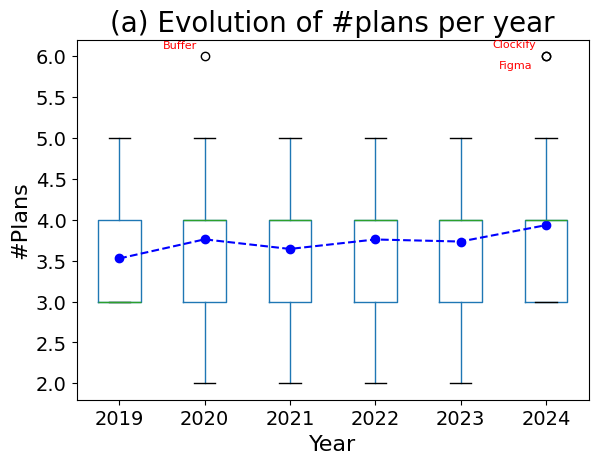

## Mean plans:

|   Year |   Plans |
|-------:|--------:|
|   2019 | 3.52632 |
|   2020 | 3.76    |
|   2021 | 3.64286 |
|   2022 | 3.75862 |
|   2023 | 3.73333 |
|   2024 | 3.93333 |

### Plans Increase:

11.542288557213931%

<Figure size 1200x800 with 0 Axes>

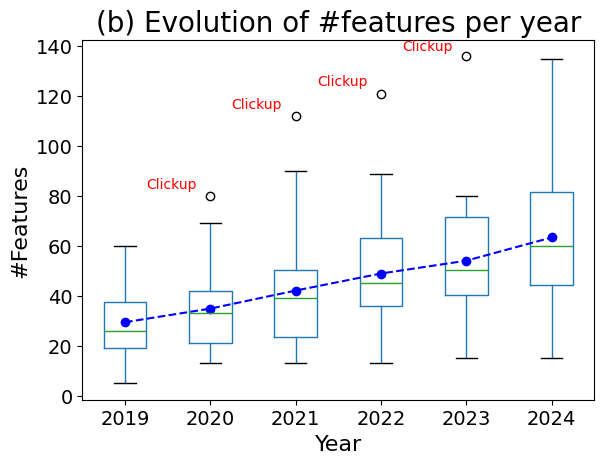

## Mean Features:

|   Year |   Features |
|-------:|-----------:|
|   2019 |    29.4737 |
|   2020 |    34.92   |
|   2021 |    42.1429 |
|   2022 |    48.9655 |
|   2023 |    54.1    |
|   2024 |    63.4    |

### Features Increase:

115.10714285714285%

<Figure size 1200x800 with 0 Axes>

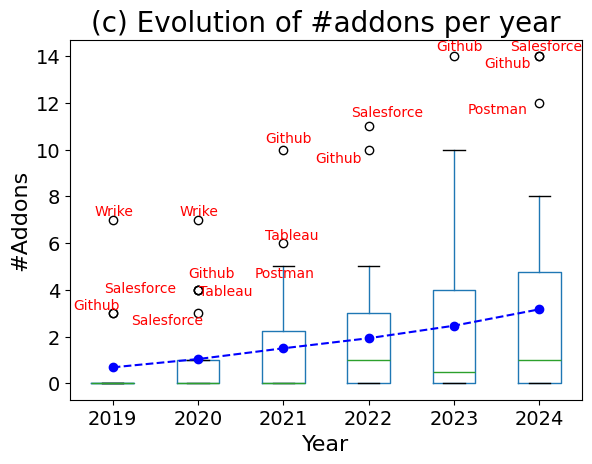

## Mean plans:

|   Year |   Addons |
|-------:|---------:|
|   2019 | 0.684211 |
|   2020 | 1.04     |
|   2021 | 1.5      |
|   2022 | 1.93103  |
|   2023 | 2.46667  |
|   2024 | 3.16667  |

### Plans Increase:

362.82051282051276%

In [85]:
from adjustText import adjust_text

titleSize=20
axisSize=16
fontSize=14
outliersSize=10
plt.rcParams.update({'font.size': fontSize})

# Draw a boxplot of plans per year
plt.figure(figsize=(12, 8))
df.boxplot(column='Plans', by='Year', grid=False)
texts = []
# Adding SaaS to outliers
for year in df['Year'].unique():
    year_data = df[df['Year'] == year]
    q1 = year_data['Plans'].quantile(0.25)
    q3 = year_data['Plans'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = year_data[(year_data['Plans'] < lower_bound) | (year_data['Plans'] > upper_bound)]
    
    for idx, row in outliers.iterrows():
        texts.append(plt.gca().text(row['Year']-2018.1, row['Plans'], row['Saas'], horizontalalignment='right', fontsize=8, color='red'))
adjust_text(texts, expand=(1.2, 2)) 

# Calculate means and add line showing its evolution
means = df.groupby('Year')['Plans'].mean()
plt.plot(means.index-2018, means.values, color='blue', marker='o', linestyle='--', label='Median')


plt.title('(a) Evolution of #plans per year', fontsize=titleSize)
plt.suptitle('')
plt.xlabel('Year', fontsize=axisSize)
plt.ylabel('#Plans',fontsize=axisSize)
plt.savefig(os.path.join(FIGURES_PATH,"SaaS_Plans_Distribution_Evolution.png"), format='png', dpi=300)
plt.show()
display(Markdown("## Mean plans:"))
display(Markdown(means.to_markdown()))
display(Markdown("### Plans Increase:"))
display(Markdown(str((means[2024]/means[2019] -1)*100)+"%"))

# Draw a boxplot of features per year
plt.figure(figsize=(12, 8))
df.boxplot(column='Features', by='Year', grid=False)
texts = []
# Adding SaaS to outliers
for year in df['Year'].unique():
    year_data = df[df['Year'] == year]
    q1 = year_data['Features'].quantile(0.25)
    q3 = year_data['Features'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = year_data[(year_data['Features'] < lower_bound) | (year_data['Features'] > upper_bound)]
    
    for idx, row in outliers.iterrows():
        texts.append(plt.gca().text(row['Year']-2018.1, row['Features'], row['Saas'], horizontalalignment='right', fontsize=10, color='red'))
adjust_text(texts, expand=(1.2, 2))   

# Calculate means and add line showing its evolution
means = df.groupby('Year')['Features'].mean()
plt.plot(means.index-2018, means.values, color='blue', marker='o', linestyle='--', label='Median')

plt.title('(b) Evolution of #features per year', fontsize=titleSize)
plt.suptitle('')
plt.xlabel('Year', fontsize=axisSize)
plt.ylabel('#Features', fontsize=axisSize)
plt.savefig(os.path.join(FIGURES_PATH,"SaaS_Features_Distribution_Evolution.png"), format='png', dpi=300)
plt.show()

display(Markdown("## Mean Features:"))
display(Markdown(means.to_markdown()))
display(Markdown("### Features Increase:"))
display(Markdown(str((means[2024]/means[2019] -1)*100)+"%"))
# Draw a boxplot of addons per year
plt.figure(figsize=(12, 8))
df.boxplot(column='Addons', by='Year', grid=False)
# Adding SaaS to outliers
texts = []
for year in df['Year'].unique():
    year_data = df[df['Year'] == year]
    q1 = year_data['Addons'].quantile(0.25)
    q3 = year_data['Addons'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = year_data[(year_data['Addons'] < lower_bound) | (year_data['Addons'] > upper_bound)]
    
    for idx, row in outliers.iterrows():
        texts.append(plt.gca().text(row['Year']-2018.1, row['Addons'], row['Saas'], horizontalalignment='right', fontsize=outliersSize, color='red'))
adjust_text(texts, expand=(1.2, 1.1))        

# Calculate means and add line showing its evolution
means = df.groupby('Year')['Addons'].mean()

plt.plot(means.index-2018, means.values, color='blue', marker='o', linestyle='--', label='Median')

plt.title('(c) Evolution of #addons per year', fontsize=titleSize)
plt.suptitle('')
plt.xlabel('Year', fontsize=axisSize)
plt.ylabel('#Addons', fontsize=axisSize)
plt.savefig(os.path.join(FIGURES_PATH,"SaaS_Addons_Distribution_Evolution.png"), format='png', dpi=300)
plt.show()

display(Markdown("## Mean add-ons:"))
display(Markdown(means.to_markdown()))
display(Markdown("### Add-ons Increase:"))
display(Markdown(str((means[2024]/means[2019] -1)*100)+"%"))

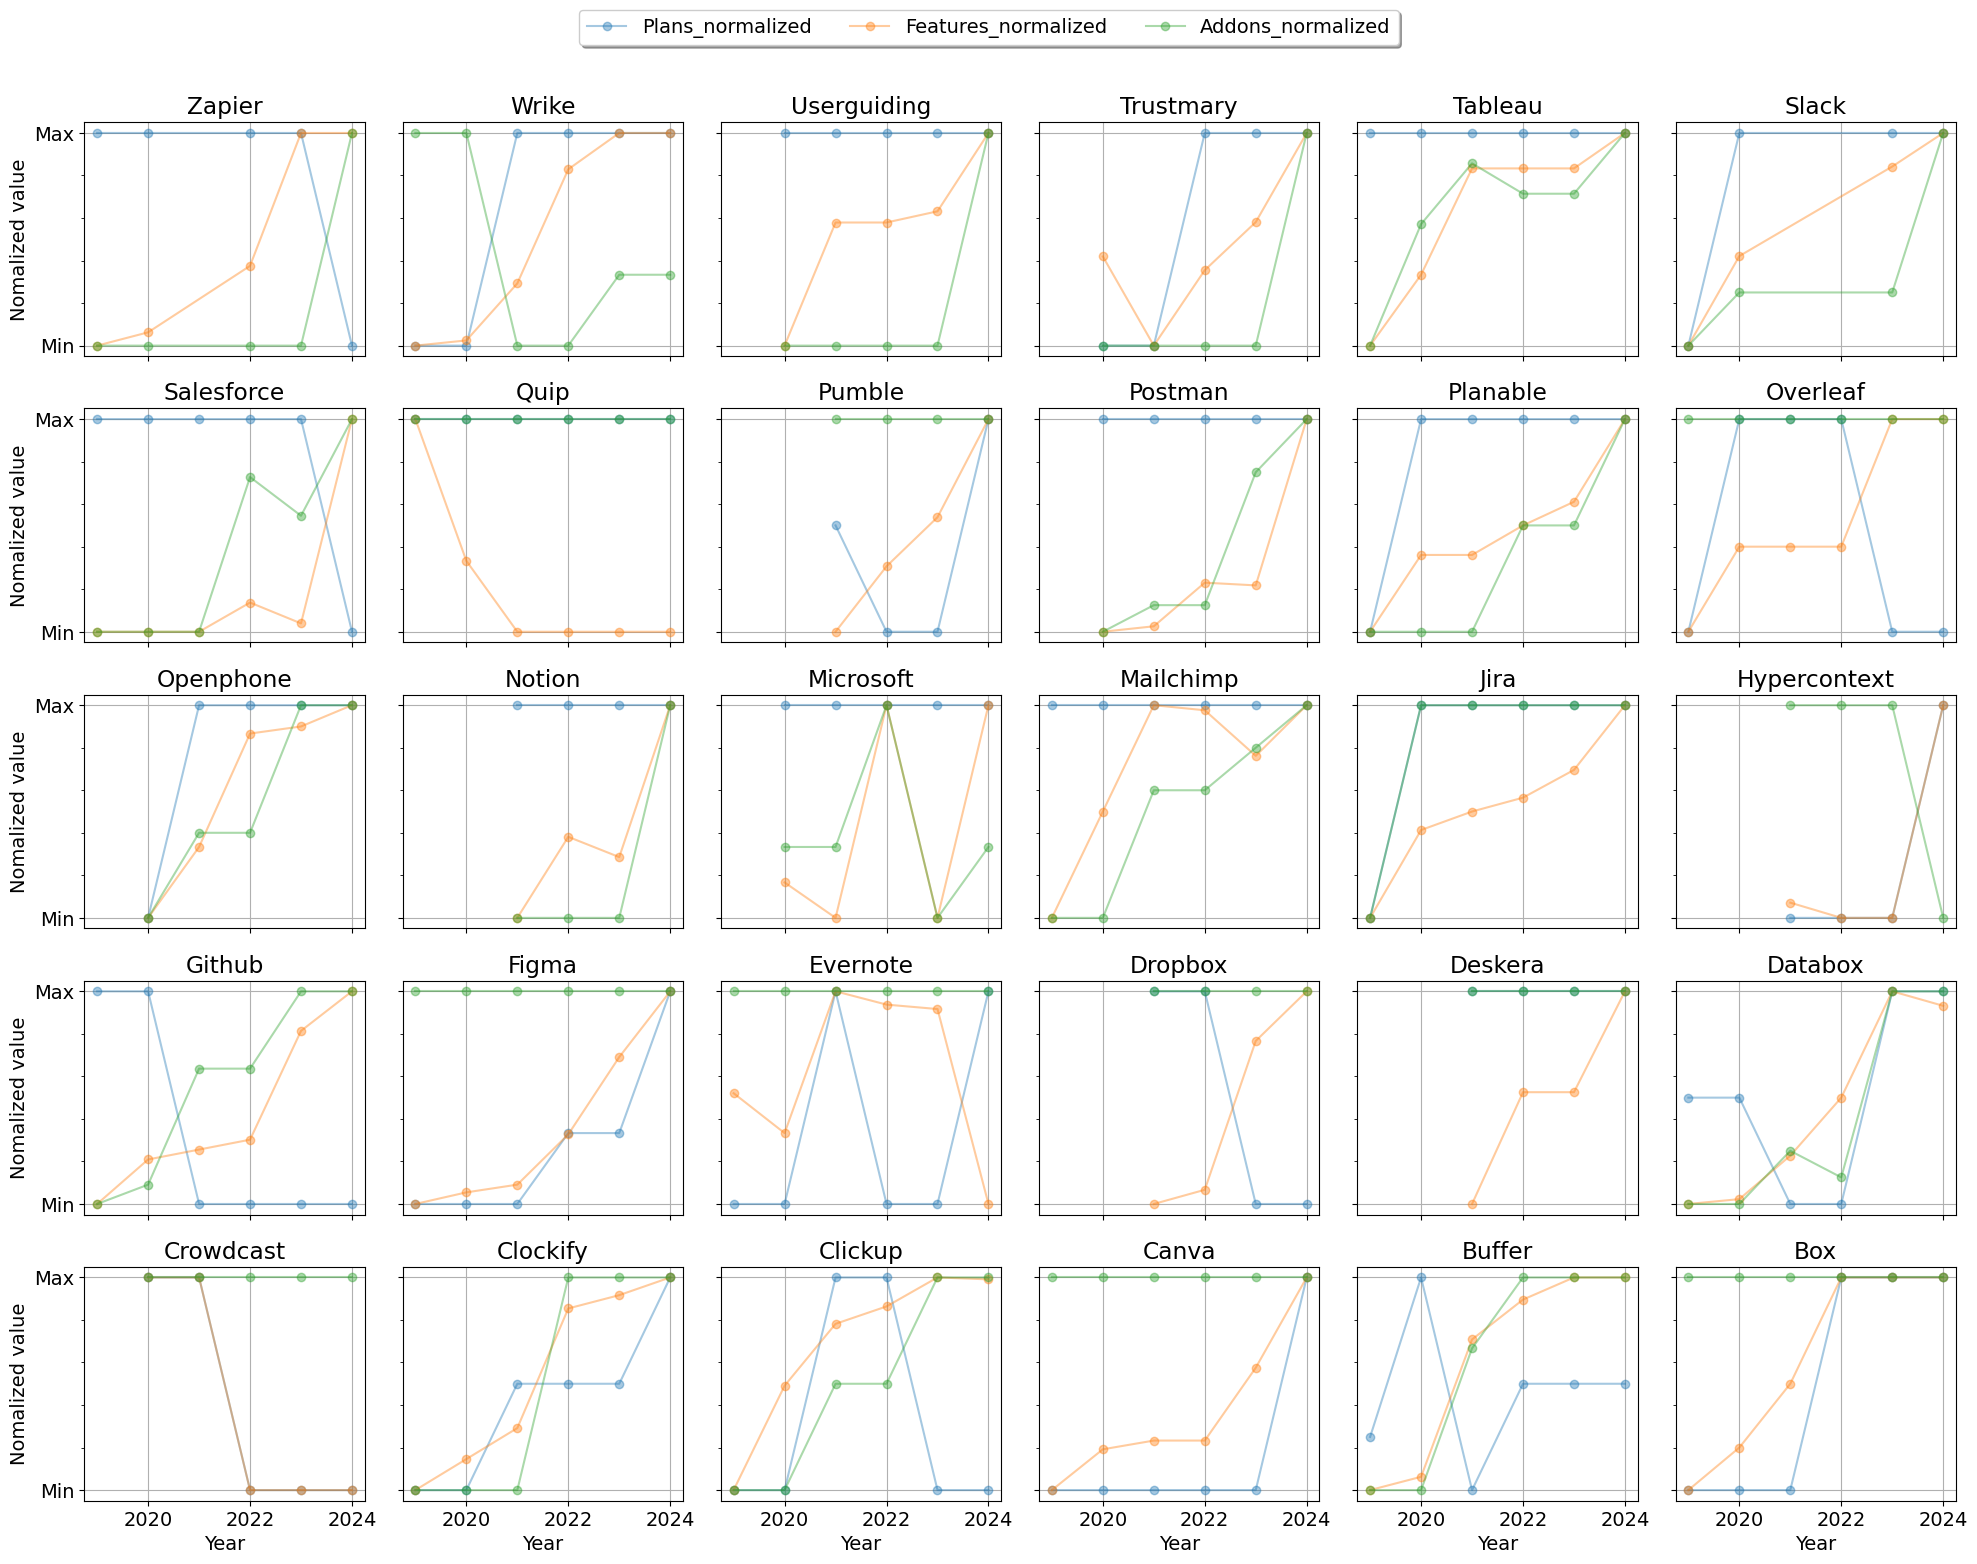

In [58]:
# Setting up the subplots as a 5x6 grid
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotting the data
saas_companies = df_normalized['Saas'].unique()
for i, saas in enumerate(saas_companies):
    df_saas = df_normalized[df_normalized['Saas'] == saas]
    ax = axes[i]
    df_saas.plot(x='Year', y=['Plans_normalized', 'Features_normalized', 'Addons_normalized'], ax=ax, marker='o', alpha=0.4)
    ax.set_title(f'{saas}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Nomalized value')
    #ax.legend(['Plans Normalized', 'Features Normalized', 'Addons Normalized'])
    ax.grid(True)
    ax.get_legend().remove()  # Remove legend from subplots

    # Customizing the x-axis labels to show 'min' and 'max'
    min_label = "Min" #f"Min: P({df_saas['Plans_min'].iloc[0]}), F({df_saas['Features_min'].iloc[0]}), A({df_saas['Addons_min'].iloc[0]})"
    max_label = "Max" #f"Max: P({df_saas['Plans_max'].iloc[0]}), F({df_saas['Features_max'].iloc[0]}), A({df_saas['Addons_max'].iloc[0]})"
    ax.set_yticks([0, 1])
    ax.set_yticklabels([min_label, max_label])

# Remove any empty subplots
#for j in range(i+1, len(axes)):
#    fig.delaxes(axes[j])

# Add a single legend at the top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True)

plt.tight_layout(rect=[0, 0, 1, 0.999])  # Adjust layout to make space for the legend
plt.tight_layout()
plt.show()


---

# ALTERNATIVES TO PREVIOUS VISUALIZATION

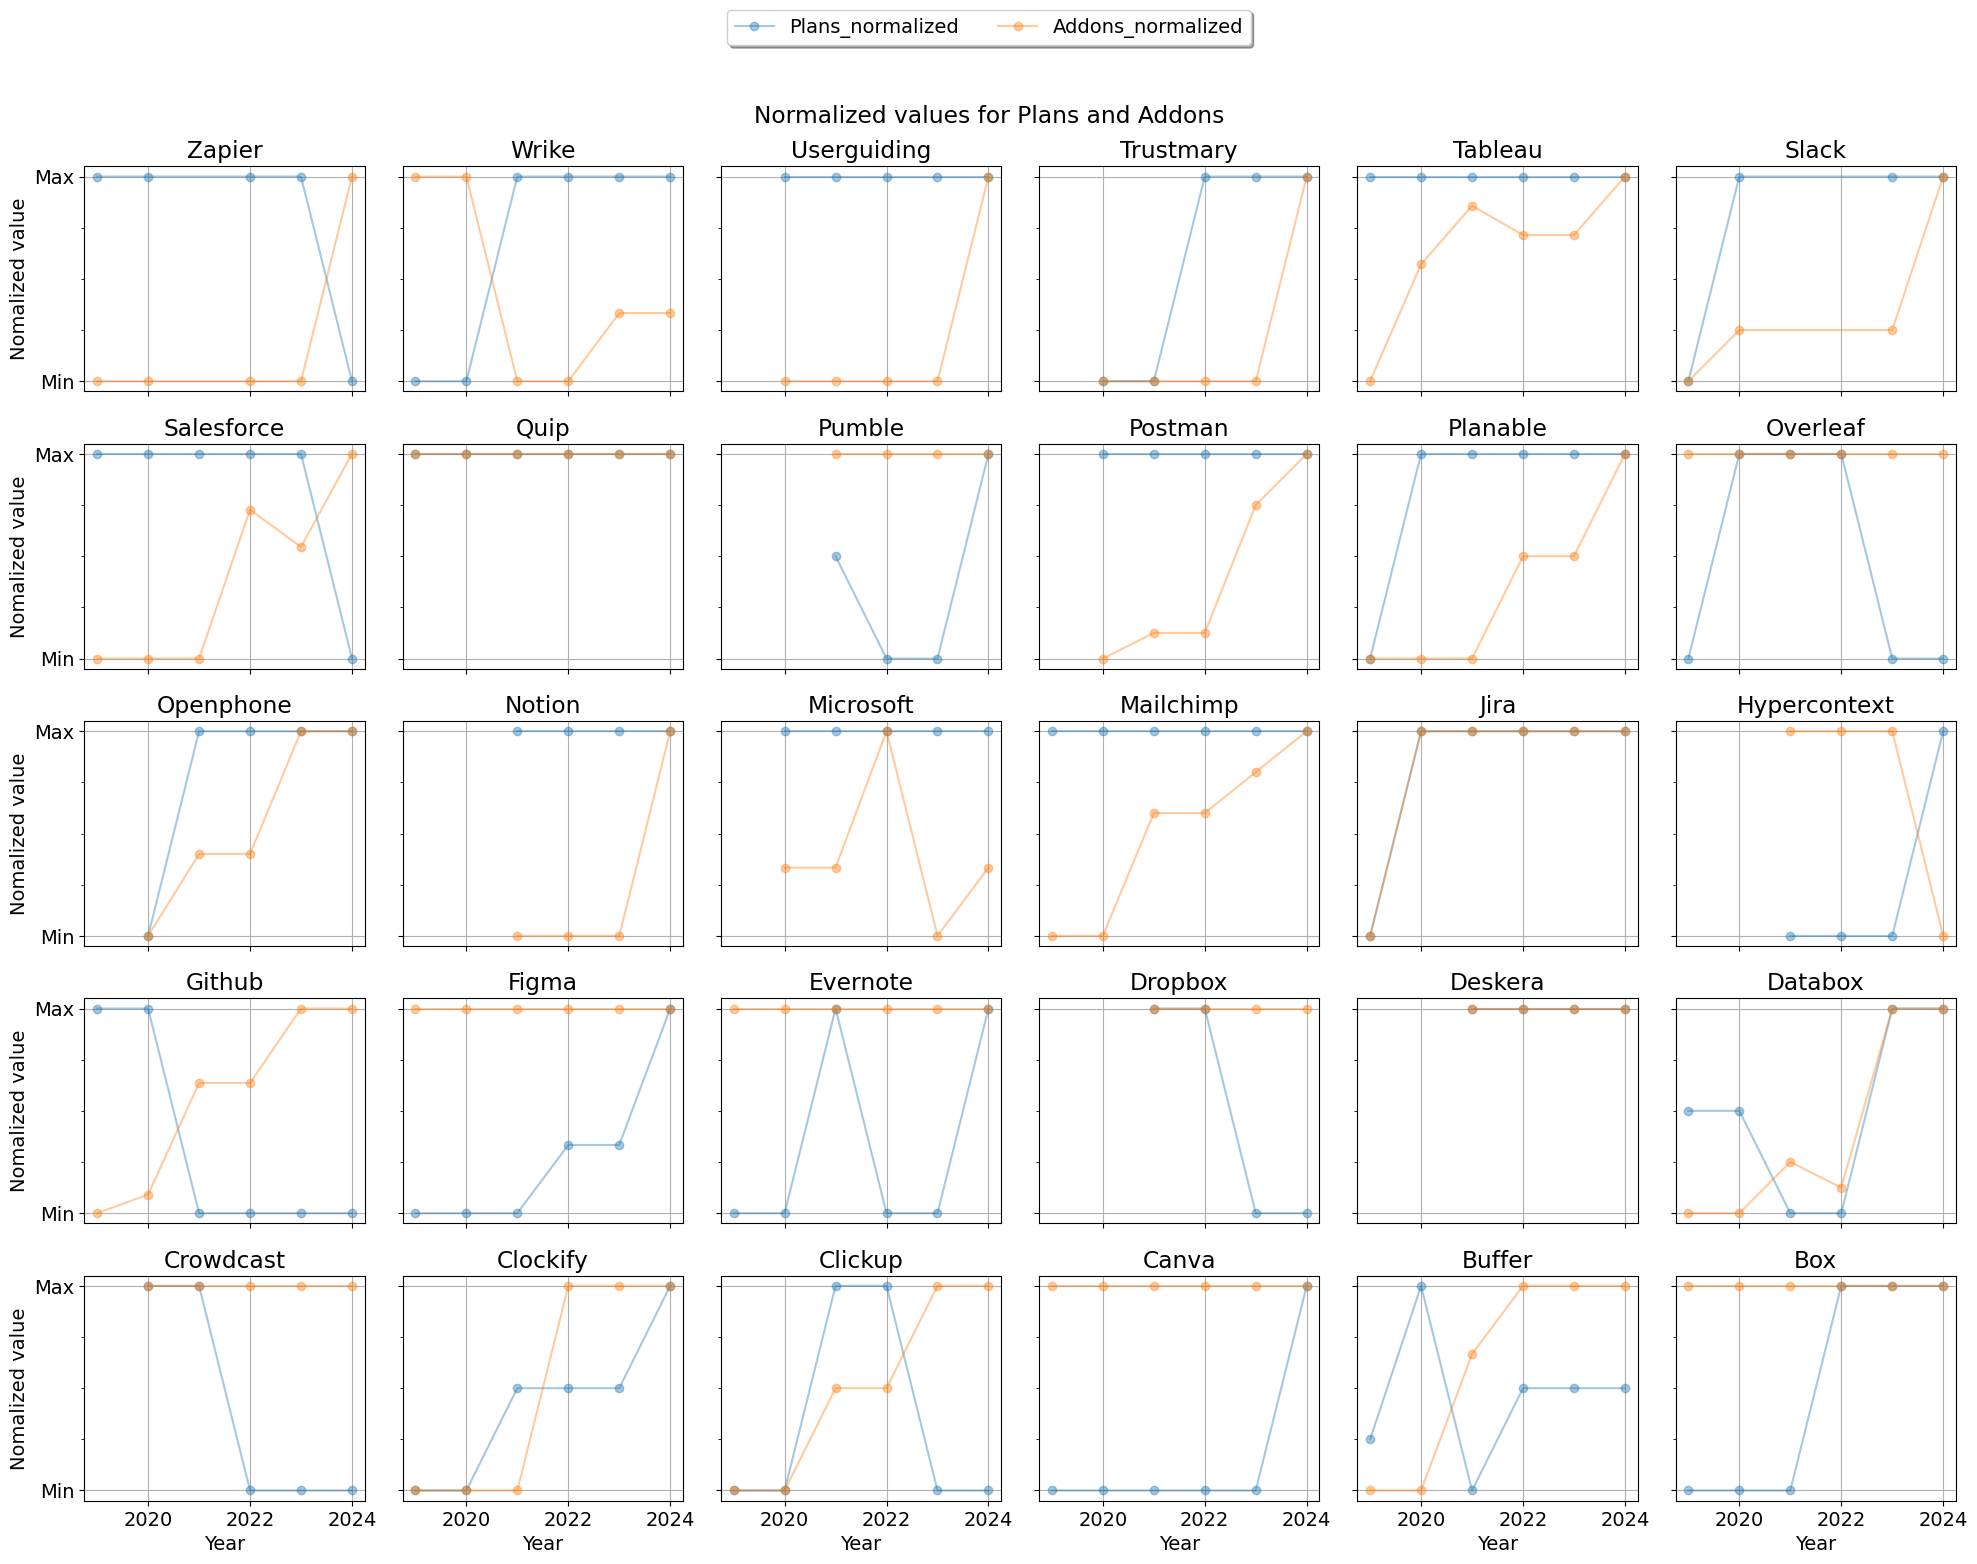

In [59]:
# Setting up the subplots as a 5x6 grid
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotting the data
saas_companies = df_normalized['Saas'].unique()
for i, saas in enumerate(saas_companies):
    df_saas = df_normalized[df_normalized['Saas'] == saas]
    ax = axes[i]
    df_saas.plot(x='Year', y=['Plans_normalized', 'Addons_normalized'], ax=ax, marker='o', alpha=0.4)
    ax.set_title(f'{saas}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Nomalized value')
    #ax.legend(['Plans Normalized', 'Features Normalized', 'Addons Normalized'])
    ax.grid(True)
    ax.get_legend().remove()  # Remove legend from subplots

    # Customizing the x-axis labels to show 'min' and 'max'
    min_label = "Min" #f"Min: P({df_saas['Plans_min'].iloc[0]}), F({df_saas['Features_min'].iloc[0]}), A({df_saas['Addons_min'].iloc[0]})"
    max_label = "Max" #f"Max: P({df_saas['Plans_max'].iloc[0]}), F({df_saas['Features_max'].iloc[0]}), A({df_saas['Addons_max'].iloc[0]})"
    ax.set_yticks([0, 1])
    ax.set_yticklabels([min_label, max_label])

# Remove any empty subplots
#for j in range(i+1, len(axes)):
#    fig.delaxes(axes[j])

# Add a single legend at the top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True)
fig.suptitle('Normalized values for Plans and Addons')

plt.tight_layout(rect=[0, 0, 1, 0.999])  # Adjust layout to make space for the legend
plt.tight_layout()
plt.show()

In [60]:
def normalize_features(df):

    col_min = 0
    col_max = df.groupby('Saas')["Features"].transform('max')
    dif = col_max - col_min                
    df['Features_normalized'] = (df["Features"] - col_min) / dif
    df['Features_normalized'] = df['Features_normalized'].where(dif != 0, 1)
    df['Features_min'] = col_min
    df['Features_max'] = col_max

    return df

df_normalized_features = normalize_features(df)

df_normalized_features

,Saas,Year,Plans,Features,Addons,Has_Many_Products,Plans_normalized,Plans_min,Plans_max,Features_normalized,Features_min,Features_max,Addons_normalized,Addons_min,Addons_max
0,Zapier,2019,5,19,0,False,1.0,4,5,0.372549,0,51,0.0,0,4
1,Zapier,2020,5,21,0,False,1.0,4,5,0.411765,0,51,0.0,0,4
2,Zapier,2022,5,31,0,False,1.0,4,5,0.607843,0,51,0.0,0,4
3,Zapier,2023,5,51,0,False,1.0,4,5,1.000000,0,51,0.0,0,4
4,Zapier,2024,4,51,4,False,0.0,4,5,1.000000,0,51,1.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,Box,2020,4,42,0,False,0.0,4,5,0.840000,0,50,1.0,0,0
157,Box,2021,4,45,0,False,0.0,4,5,0.900000,0,50,1.0,0,0
158,Box,2022,5,50,0,False,1.0,4,5,1.000000,0,50,1.0,0,0
159,Box,2023,5,50,0,False,1.0,4,5,1.000000,0,50,1.0,0,0


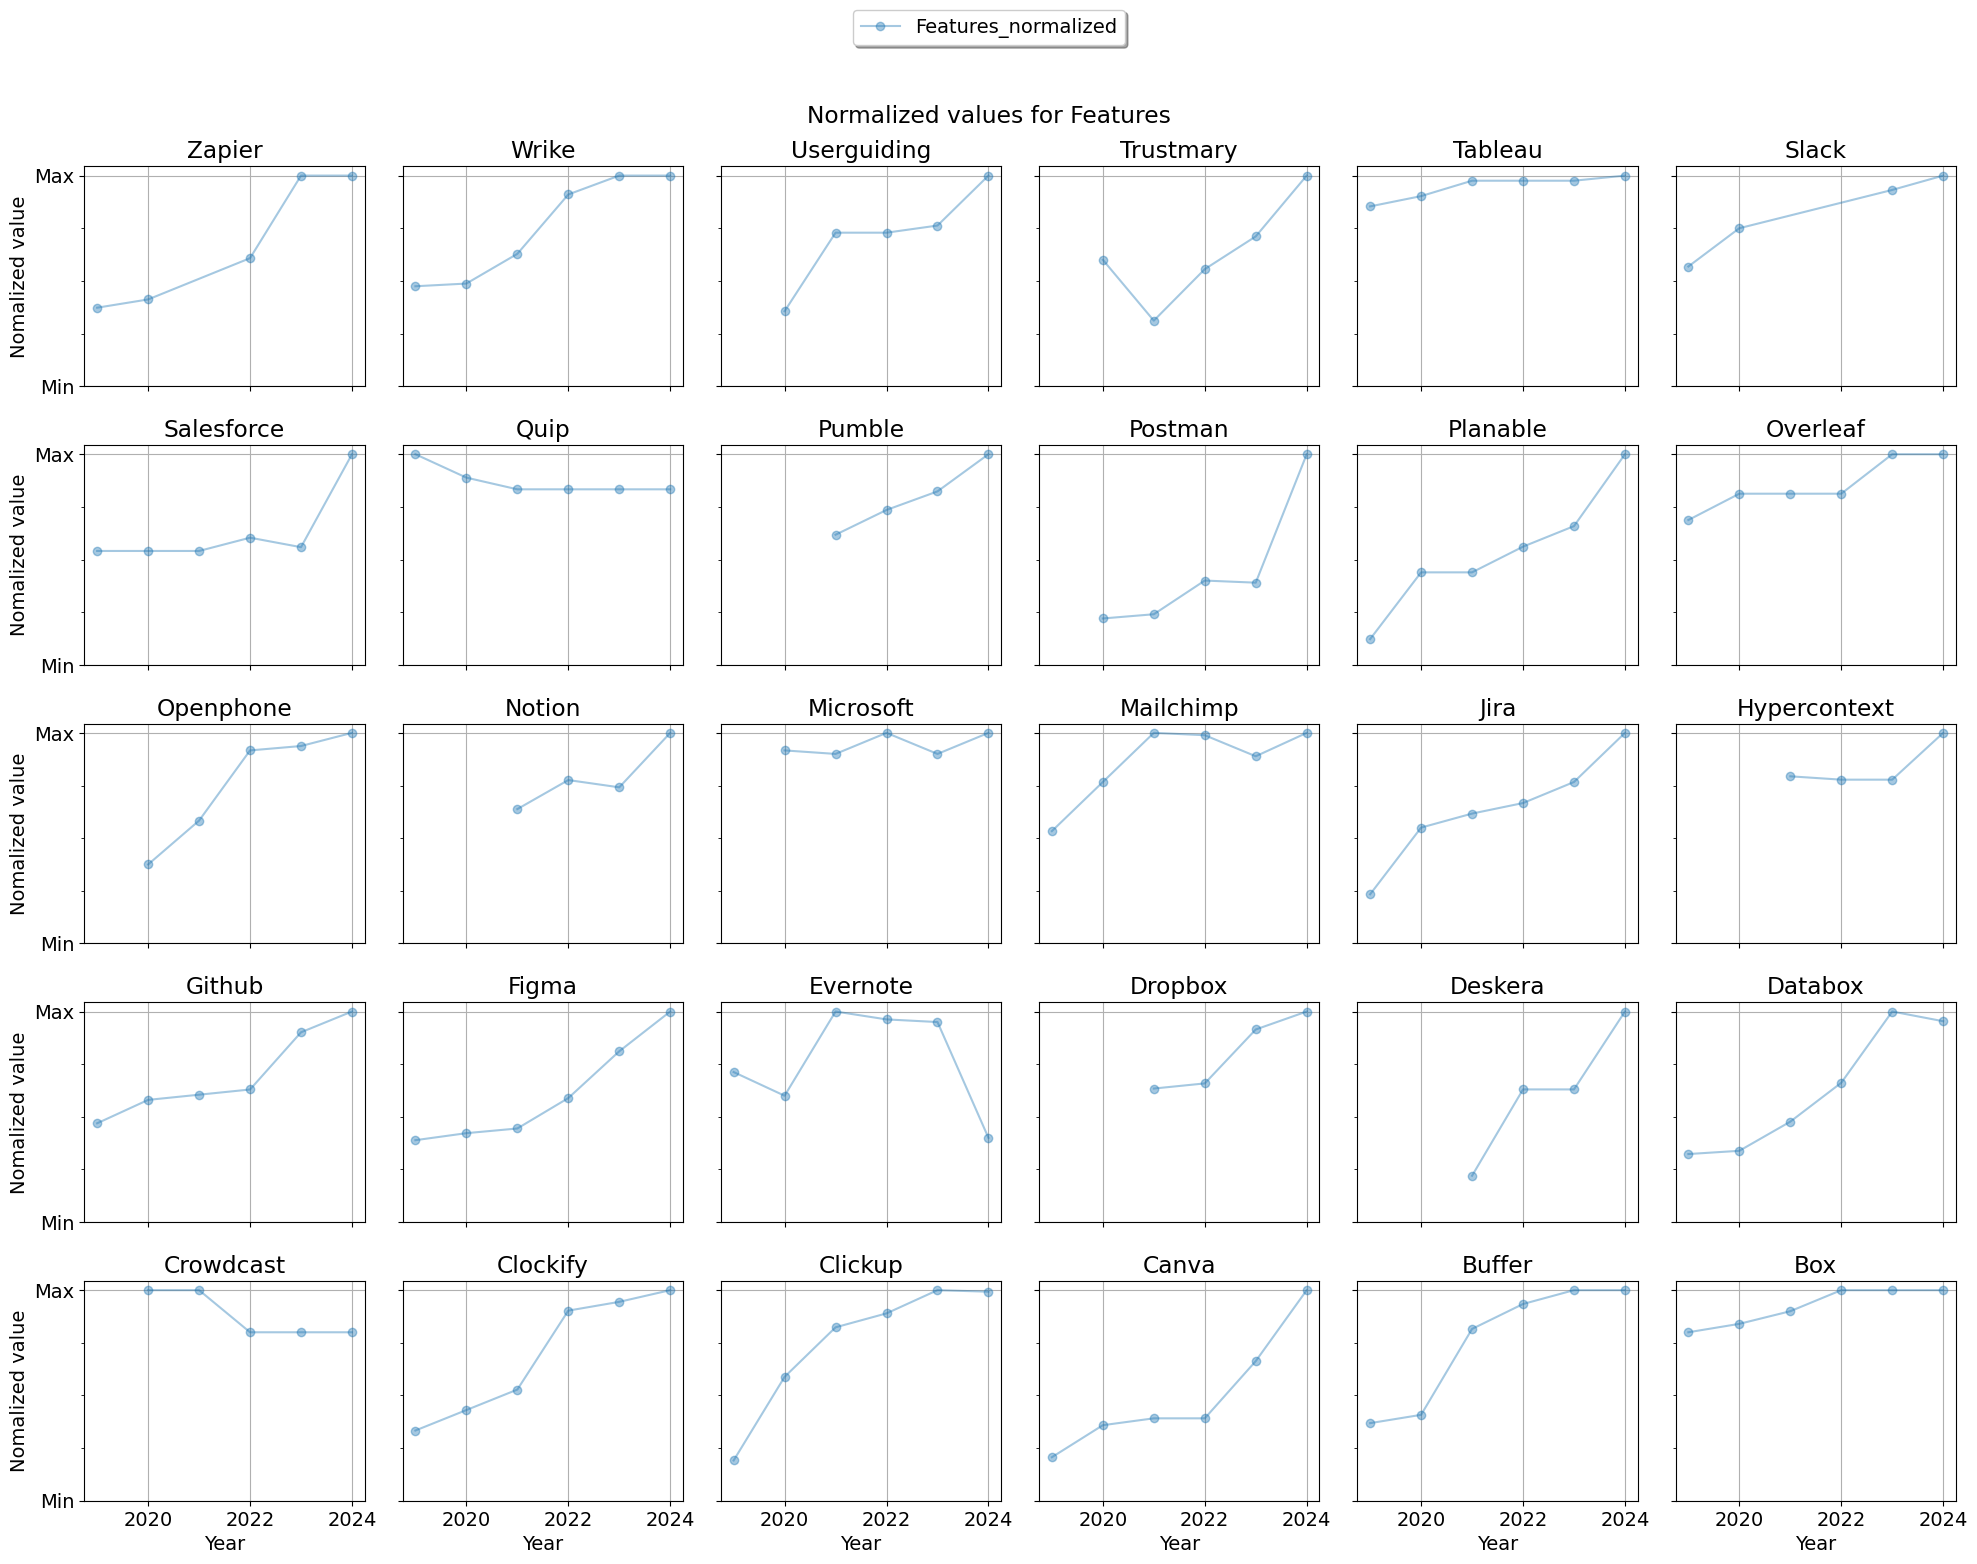

In [61]:
# Setting up the subplots as a 5x6 grid
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotting the data
saas_companies = df_normalized_features['Saas'].unique()
for i, saas in enumerate(saas_companies):
    df_saas = df_normalized_features[df_normalized_features['Saas'] == saas]
    ax = axes[i]
    df_saas.plot(x='Year', y='Features_normalized', ax=ax, marker='o', alpha=0.4)
    ax.set_title(f'{saas}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Nomalized value')
    #ax.legend(['Plans Normalized', 'Features Normalized', 'Addons Normalized'])
    ax.grid(True)
    ax.get_legend().remove()  # Remove legend from subplots

    # Customizing the x-axis labels to show 'min' and 'max'
    min_label = "Min" #f"Min: P({df_saas['Plans_min'].iloc[0]}), F({df_saas['Features_min'].iloc[0]}), A({df_saas['Addons_min'].iloc[0]})"
    max_label = "Max" #f"Max: P({df_saas['Plans_max'].iloc[0]}), F({df_saas['Features_max'].iloc[0]}), A({df_saas['Addons_max'].iloc[0]})"
    ax.set_yticks([0, 1])
    ax.set_yticklabels([min_label, max_label])

# Remove any empty subplots
#for j in range(i+1, len(axes)):
#    fig.delaxes(axes[j])

# Add a single legend at the top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True)
fig.suptitle('Normalized values for Features')

plt.tight_layout(rect=[0, 0, 1, 0.999])  # Adjust layout to make space for the legend
plt.tight_layout()
plt.show()

---

In [67]:
multiple_products_df = df.copy()
multiple_products_df = multiple_products_df[multiple_products_df['Has_Many_Products'] == True]
single_products_df = df.copy()
single_products_df = single_products_df[single_products_df['Has_Many_Products'] == False]

In [68]:
multiple_products_df['Feature_Percentage_Change'] = multiple_products_df.groupby('Saas')['Features'].pct_change() * 100

# Filter the rows where the variation is valid (not NaN)
multiple_products_df_valid = multiple_products_df.dropna(subset=['Feature_Percentage_Change'])

single_products_df['Feature_Percentage_Change'] = single_products_df.groupby('Saas')['Features'].pct_change() * 100

# Filter the rows where the variation is valid (not NaN)
single_products_df_valid = single_products_df.dropna(subset=['Feature_Percentage_Change'])

AMOUNT OF SINGLE PRODUCT SAAS: 27
AMOUNT OF MULTIPLE PRODUCT SAAS: 6


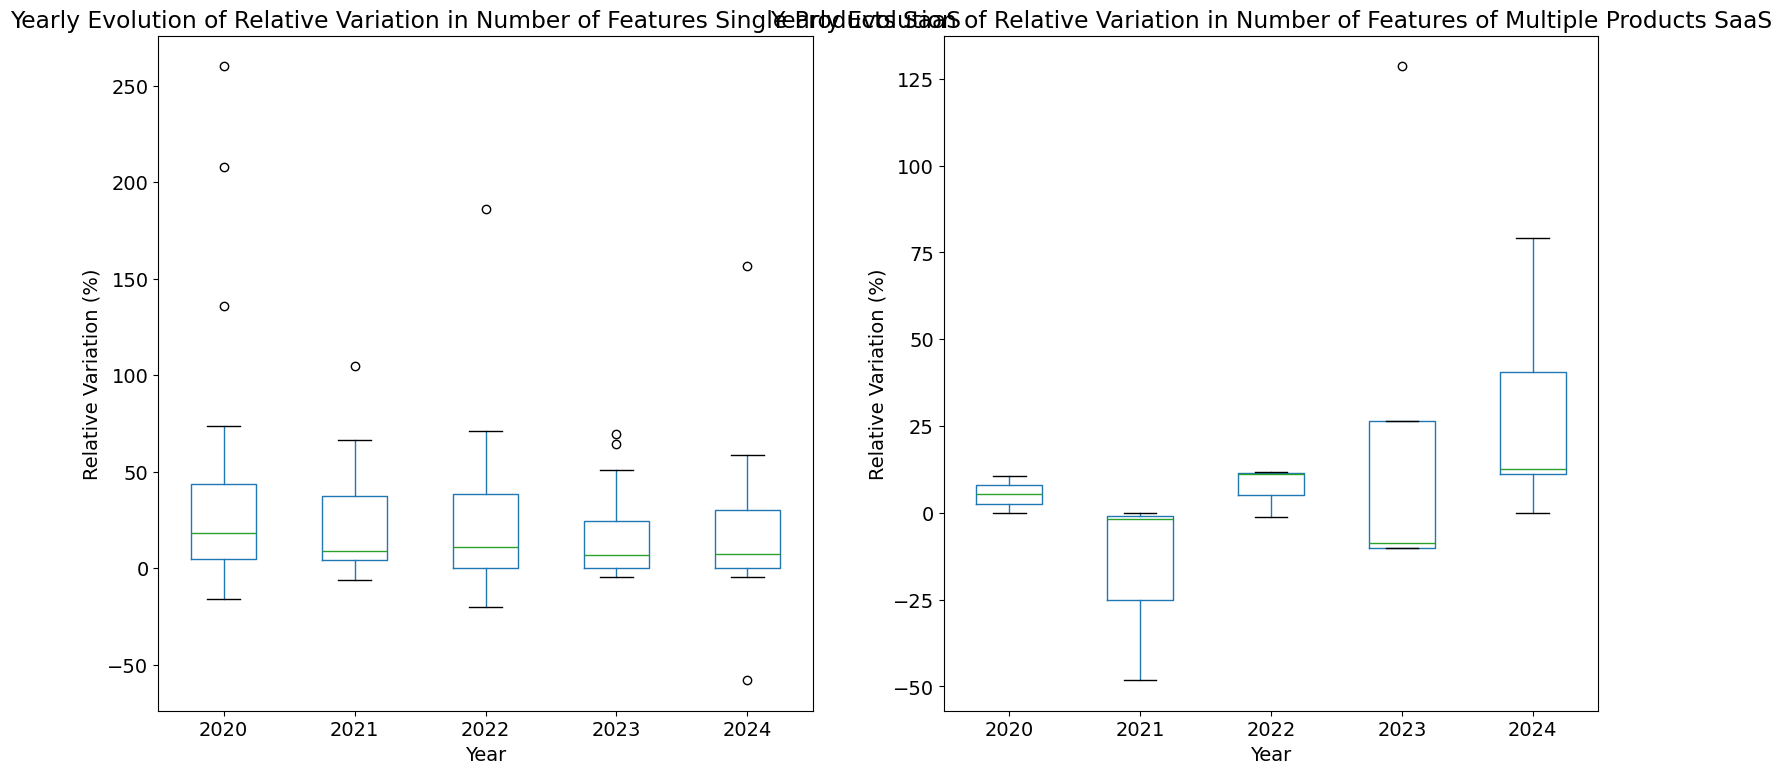

In [69]:
amount_of_single_products = len(single_products_df_valid['Saas'].unique())
amount_of_multiple_products = len(multiple_products_df_valid['Saas'].unique())

print(f"AMOUNT OF SINGLE PRODUCT SAAS: {amount_of_single_products}")
print(f"AMOUNT OF MULTIPLE PRODUCT SAAS: {amount_of_multiple_products}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

single_products_df_valid.boxplot(column='Feature_Percentage_Change', by='Year', grid=False, ax=ax1)
ax1.set_title('Yearly Evolution of Relative Variation in\nNumber of Features Single Products SaaS')
ax1.set_xlabel('Year')
ax1.set_ylabel('Relative Variation (%)')

multiple_products_df_valid.boxplot(column='Feature_Percentage_Change', by='Year', grid=False, ax=ax2)
ax2.set_title('Yearly Evolution of Relative Variation in\nNumber of Features of Multiple Products SaaS')
ax2.set_xlabel('Year')
ax2.set_ylabel('Relative Variation (%)')

fig.suptitle('')  # Suppress the title

plt.show()

In [71]:
def get_subscriptions_data_from_dataset(dataset):
    data = {}

    for i in range(len(dataset)):
        pricing: PricingManager = dataset[i]
        saas_index_name = pricing.saas_name.split(" ")[0].strip().lower().capitalize()
        if saas_index_name.lower() == "office":
            continue
        if saas_index_name not in data:
            data[saas_index_name] = {year: None for year in STUDIED_YEARS}
        
        data[saas_index_name][str(pricing.year)] = {}
        data[saas_index_name][str(pricing.year)]["Subscriptions"] = calculate_subscriptions(pricing)
        data[saas_index_name][str(pricing.year)]["Has_add_ons"] = len(pricing.add_ons) > 0

    data_items = sorted(data.items(), key=lambda x: x[0])
    data = dict(data_items)

    return data

def build_subscriptions_dataframe(data):
    # Initializing a list to store the records
    records = []

    # Iterating through the nested dictionary
    for saas, years in data.items():
        for year, metrics in years.items():
            if metrics is not None:  # Verifing if there are available metrics for that year
                # Creating a register with the specific structure
                record = {
                    'Saas': saas,
                    'Year': int(year),
                    'Subscriptions': metrics["Subscriptions"],
                    'Has_add_ons': metrics["Has_add_ons"]
                }
                records.append(record)

    # Transforming the list of records into a DataFrame
    df = pd.DataFrame(records, columns=['Saas', 'Year', 'Subscriptions', "Has_add_ons"])
    return df

subscriptions_data = get_subscriptions_data_from_dataset(dataset)
subscriptions_df = build_subscriptions_dataframe(subscriptions_data)
display(Markdown("# Subscriptions Data"))
display(Markdown(subscriptions_df.to_markdown()))

# Subscriptions Data

|     | Saas         |   Year |   Subscriptions | Has_add_ons   |
|----:|:-------------|-------:|----------------:|:--------------|
|   0 | Box          |   2019 |               4 | False         |
|   1 | Box          |   2020 |               4 | False         |
|   2 | Box          |   2021 |               4 | False         |
|   3 | Box          |   2022 |               5 | False         |
|   4 | Box          |   2023 |               5 | False         |
|   5 | Box          |   2024 |               5 | False         |
|   6 | Buffer       |   2019 |               3 | False         |
|   7 | Buffer       |   2020 |               6 | False         |
|   8 | Buffer       |   2021 |               5 | True          |
|   9 | Buffer       |   2022 |               7 | True          |
|  10 | Buffer       |   2023 |               7 | True          |
|  11 | Buffer       |   2024 |               7 | True          |
|  12 | Canva        |   2019 |               3 | False         |
|  13 | Canva        |   2020 |               3 | False         |
|  14 | Canva        |   2021 |               3 | False         |
|  15 | Canva        |   2022 |               3 | False         |
|  16 | Canva        |   2023 |               3 | False         |
|  17 | Canva        |   2024 |               4 | False         |
|  18 | Clickup      |   2019 |               4 | False         |
|  19 | Clickup      |   2020 |               4 | False         |
|  20 | Clickup      |   2021 |               9 | True          |
|  21 | Clickup      |   2022 |               9 | True          |
|  22 | Clickup      |   2023 |              13 | True          |
|  23 | Clickup      |   2024 |              13 | True          |
|  24 | Clockify     |   2019 |               4 | False         |
|  25 | Clockify     |   2020 |               4 | False         |
|  26 | Clockify     |   2021 |               5 | False         |
|  27 | Clockify     |   2022 |               9 | True          |
|  28 | Clockify     |   2023 |               9 | True          |
|  29 | Clockify     |   2024 |              10 | True          |
|  30 | Crowdcast    |   2020 |               4 | False         |
|  31 | Crowdcast    |   2021 |               4 | False         |
|  32 | Crowdcast    |   2022 |               3 | False         |
|  33 | Crowdcast    |   2023 |               3 | False         |
|  34 | Crowdcast    |   2024 |               3 | False         |
|  35 | Databox      |   2019 |               4 | False         |
|  36 | Databox      |   2020 |               4 | False         |
|  37 | Databox      |   2021 |               9 | True          |
|  38 | Databox      |   2022 |               5 | True          |
|  39 | Databox      |   2023 |             786 | True          |
|  40 | Databox      |   2024 |             786 | True          |
|  41 | Deskera      |   2021 |               3 | False         |
|  42 | Deskera      |   2022 |               3 | False         |
|  43 | Deskera      |   2023 |               3 | False         |
|  44 | Deskera      |   2024 |               3 | False         |
|  45 | Dropbox      |   2021 |               5 | False         |
|  46 | Dropbox      |   2022 |               5 | False         |
|  47 | Dropbox      |   2023 |               4 | False         |
|  48 | Dropbox      |   2024 |               4 | False         |
|  49 | Evernote     |   2019 |               3 | False         |
|  50 | Evernote     |   2020 |               3 | False         |
|  51 | Evernote     |   2021 |               4 | False         |
|  52 | Evernote     |   2022 |               3 | False         |
|  53 | Evernote     |   2023 |               3 | False         |
|  54 | Evernote     |   2024 |               4 | False         |
|  55 | Figma        |   2019 |               3 | False         |
|  56 | Figma        |   2020 |               3 | False         |
|  57 | Figma        |   2021 |               3 | False         |
|  58 | Figma        |   2022 |               4 | False         |
|  59 | Figma        |   2023 |               4 | False         |
|  60 | Figma        |   2024 |               6 | False         |
|  61 | Github       |   2019 |              11 | True          |
|  62 | Github       |   2020 |              14 | True          |
|  63 | Github       |   2021 |            1152 | True          |
|  64 | Github       |   2022 |            1152 | True          |
|  65 | Github       |   2023 |            8960 | True          |
|  66 | Github       |   2024 |            8960 | True          |
|  67 | Hypercontext |   2021 |               4 | True          |
|  68 | Hypercontext |   2022 |               4 | True          |
|  69 | Hypercontext |   2023 |               4 | True          |
|  70 | Hypercontext |   2024 |               4 | False         |
|  71 | Jira         |   2019 |               3 | False         |
|  72 | Jira         |   2020 |               7 | True          |
|  73 | Jira         |   2021 |               7 | True          |
|  74 | Jira         |   2022 |               7 | True          |
|  75 | Jira         |   2023 |               7 | True          |
|  76 | Jira         |   2024 |               7 | True          |
|  77 | Mailchimp    |   2019 |               4 | False         |
|  78 | Mailchimp    |   2020 |               4 | False         |
|  79 | Mailchimp    |   2021 |              26 | True          |
|  80 | Mailchimp    |   2022 |              26 | True          |
|  81 | Mailchimp    |   2023 |              11 | True          |
|  82 | Mailchimp    |   2024 |              15 | True          |
|  83 | Microsoft    |   2020 |               7 | True          |
|  84 | Microsoft    |   2021 |               7 | True          |
|  85 | Microsoft    |   2022 |              13 | True          |
|  86 | Microsoft    |   2023 |               4 | False         |
|  87 | Microsoft    |   2024 |               8 | True          |
|  88 | Notion       |   2021 |               4 | False         |
|  89 | Notion       |   2022 |               4 | False         |
|  90 | Notion       |   2023 |               4 | False         |
|  91 | Notion       |   2024 |               7 | True          |
|  92 | Openphone    |   2020 |               4 | True          |
|  93 | Openphone    |   2021 |              24 | True          |
|  94 | Openphone    |   2022 |              24 | True          |
|  95 | Openphone    |   2023 |             192 | True          |
|  96 | Openphone    |   2024 |             192 | True          |
|  97 | Overleaf     |   2019 |               3 | False         |
|  98 | Overleaf     |   2020 |               4 | False         |
|  99 | Overleaf     |   2021 |               4 | False         |
| 100 | Overleaf     |   2022 |               4 | False         |
| 101 | Overleaf     |   2023 |               3 | False         |
| 102 | Overleaf     |   2024 |               3 | False         |
| 103 | Planable     |   2019 |               3 | False         |
| 104 | Planable     |   2020 |               4 | False         |
| 105 | Planable     |   2021 |               4 | False         |
| 106 | Planable     |   2022 |               6 | True          |
| 107 | Planable     |   2023 |               6 | True          |
| 108 | Planable     |   2024 |              13 | True          |
| 109 | Postman      |   2020 |              64 | True          |
| 110 | Postman      |   2021 |             112 | True          |
| 111 | Postman      |   2022 |             112 | True          |
| 112 | Postman      |   2023 |            1792 | True          |
| 113 | Postman      |   2024 |            1412 | True          |
| 114 | Pumble       |   2021 |               3 | False         |
| 115 | Pumble       |   2022 |               2 | False         |
| 116 | Pumble       |   2023 |               2 | False         |
| 117 | Pumble       |   2024 |               4 | False         |
| 118 | Quip         |   2019 |               3 | False         |
| 119 | Quip         |   2020 |               3 | False         |
| 120 | Quip         |   2021 |               3 | False         |
| 121 | Quip         |   2022 |               3 | False         |
| 122 | Quip         |   2023 |               3 | False         |
| 123 | Quip         |   2024 |               3 | False         |
| 124 | Salesforce   |   2019 |              10 | True          |
| 125 | Salesforce   |   2020 |              10 | True          |
| 126 | Salesforce   |   2021 |              10 | True          |
| 127 | Salesforce   |   2022 |            1042 | True          |
| 128 | Salesforce   |   2023 |             522 | True          |
| 129 | Salesforce   |   2024 |           12544 | True          |
| 130 | Slack        |   2019 |               3 | False         |
| 131 | Slack        |   2020 |               5 | True          |
| 132 | Slack        |   2023 |               5 | True          |
| 133 | Slack        |   2024 |              21 | True          |
| 134 | Tableau      |   2019 |               3 | False         |
| 135 | Tableau      |   2020 |               8 | True          |
| 136 | Tableau      |   2021 |              24 | True          |
| 137 | Tableau      |   2022 |              16 | True          |
| 138 | Tableau      |   2023 |              16 | True          |
| 139 | Tableau      |   2024 |              48 | True          |
| 140 | Trustmary    |   2020 |               3 | False         |
| 141 | Trustmary    |   2021 |               3 | False         |
| 142 | Trustmary    |   2022 |               4 | False         |
| 143 | Trustmary    |   2023 |               4 | False         |
| 144 | Trustmary    |   2024 |               8 | True          |
| 145 | Userguiding  |   2020 |               3 | False         |
| 146 | Userguiding  |   2021 |               3 | False         |
| 147 | Userguiding  |   2022 |               3 | False         |
| 148 | Userguiding  |   2023 |               3 | False         |
| 149 | Userguiding  |   2024 |               4 | True          |
| 150 | Wrike        |   2019 |             194 | True          |
| 151 | Wrike        |   2020 |             194 | True          |
| 152 | Wrike        |   2021 |              42 | True          |
| 153 | Wrike        |   2022 |              42 | True          |
| 154 | Wrike        |   2023 |              85 | True          |
| 155 | Wrike        |   2024 |              85 | True          |
| 156 | Zapier       |   2019 |               5 | False         |
| 157 | Zapier       |   2020 |               5 | False         |
| 158 | Zapier       |   2022 |               5 | False         |
| 159 | Zapier       |   2023 |               5 | False         |
| 160 | Zapier       |   2024 |              40 | True          |

<Figure size 1200x800 with 0 Axes>

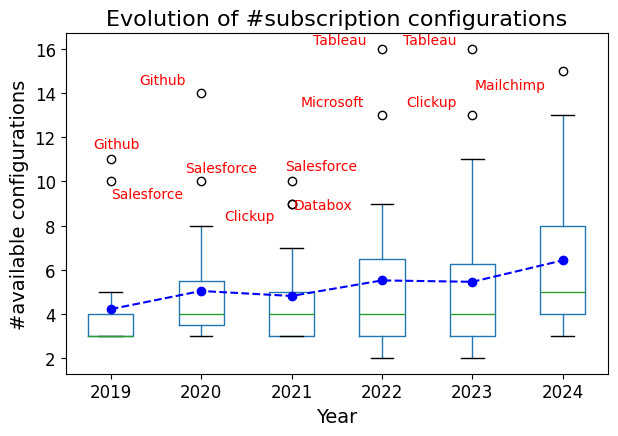

In [73]:
plt.figure(figsize=(12, 8))
subscriptions_df_filtered.boxplot(column='Subscriptions', by='Year', grid=False)
plt.title('Evolution of #subscription configurations', fontdict={'fontsize': 16})
plt.suptitle('')  # Suppress the title
plt.xlabel('Year', fontdict={'fontsize': 14})
plt.xticks(fontsize=12)
plt.ylabel('#available configurations', fontdict={'fontsize': 14})
plt.yticks(fontsize=12)

# Adding SaaS to outliers
texts = []
for year in df['Year'].unique():
    year_data = subscriptions_df_filtered[subscriptions_df_filtered['Year'] == year]
    q1 = year_data['Subscriptions'].quantile(0.25)
    q3 = year_data['Subscriptions'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = year_data[(year_data['Subscriptions'] < lower_bound) | (year_data['Subscriptions'] > upper_bound)]
    
    for idx, row in outliers.iterrows():
        texts.append(plt.gca().text(row['Year']-2018.1, row['Subscriptions'], row['Saas'], horizontalalignment='right', fontsize=10, color='red'))
adjust_text(texts, expand=(1.2, 2))    

# Calculate means and add line showing its evolution
means = subscriptions_df_filtered.groupby('Year')['Subscriptions'].mean()
plt.plot(means.index-2018, means.values, color='blue', marker='o', linestyle='--', label='Median')
plt.savefig(os.path.join(FIGURES_PATH,"SaaS_Available_Subscription_Configurations_Evolution.png"), format='png', dpi=800, bbox_inches = 'tight')
plt.tight_layout()
plt.show()

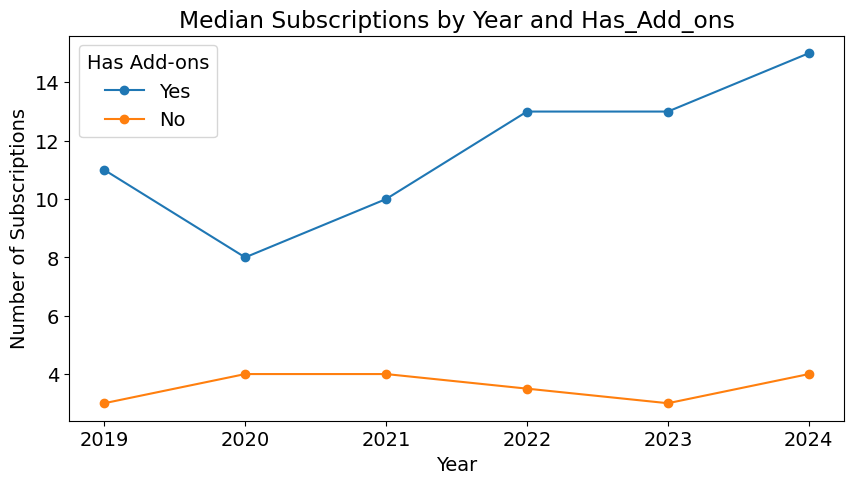

In [74]:
plt.figure(figsize=(10, 5))
subscriptions_df[subscriptions_df['Has_add_ons'] == True].groupby('Year')['Subscriptions'].median().plot(marker='o')
subscriptions_df[subscriptions_df['Has_add_ons'] == False].groupby('Year')['Subscriptions'].median().plot(marker='o')
plt.title('Median Subscriptions by Year and Has_Add_ons')
plt.xlabel('Year')
plt.ylabel('Number of Subscriptions')
plt.legend(title='Has Add-ons', labels=['Yes', 'No'])
plt.show()

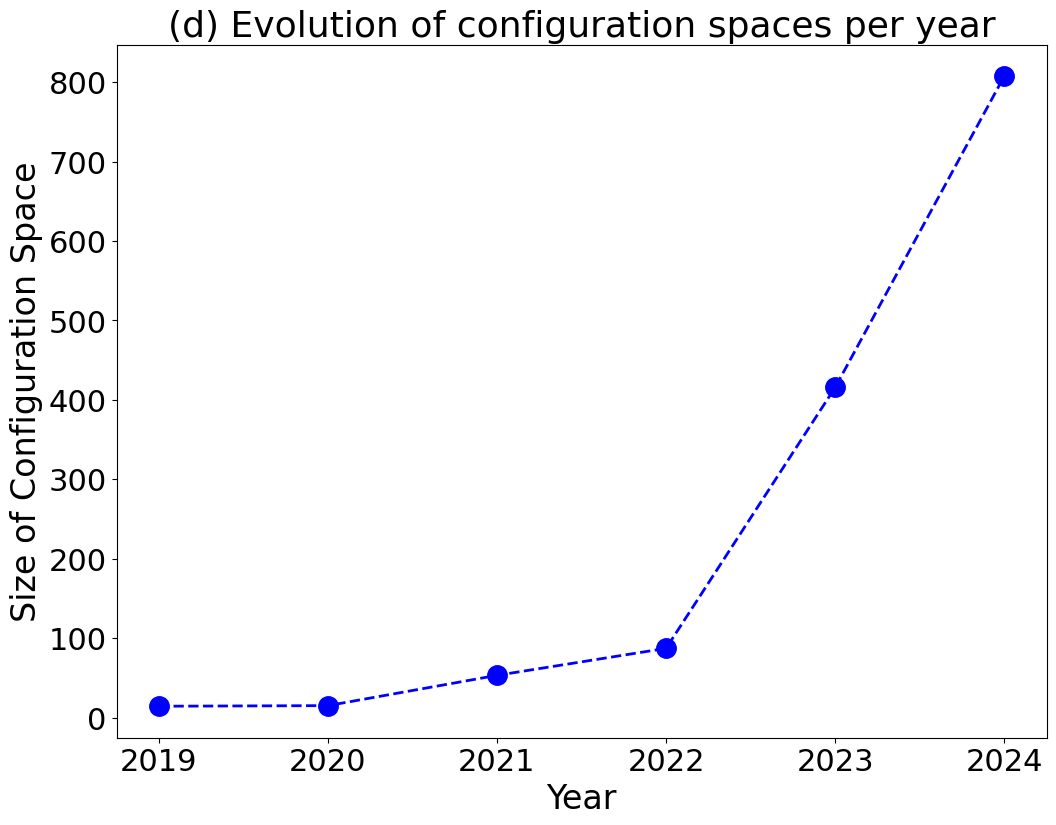

## Mean Size of Configuration Spaces of SaaS:

|   Year |   Subscriptions |
|-------:|----------------:|
|   2019 |         14.2105 |
|   2020 |         14.96   |
|   2021 |         53.0714 |
|   2022 |         87.069  |
|   2023 |        415.6    |
|   2024 |        807.433  |

### #Size of Configuration Spaces Increase:

5581.938271604938%

In [84]:
plt.figure(figsize=(12, 9))
subscriptions_df.groupby('Year')['Subscriptions'].mean().plot(marker='o', linestyle='--', markersize=14, linewidth=2, color='blue')
plt.title('(d) Evolution of configuration spaces per year', fontdict={'fontsize': 26})
plt.xlabel('Year', fontdict={'fontsize': 24})
plt.ylabel('Size of Configuration Space', fontdict={'fontsize': 24})
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.savefig(os.path.join(FIGURES_PATH,"SaaS_Available_Subscription_Configurations_Evolution_Line.png"), format='png', dpi=800, bbox_inches = 'tight')
plt.show()
means =subscriptions_df.groupby('Year')['Subscriptions'].mean()
display(Markdown("## Mean Size of Configuration Spaces of SaaS:"))
display(Markdown(means.to_markdown()))
display(Markdown("### #Size of Configuration Spaces Increase:"))
display(Markdown(str((means[2024]/means[2019] -1)*100)+"%"))


In [79]:
def normalize_subscriptions(df):

    col_min = df.groupby('Saas')["Subscriptions"].transform('min')
    col_max = df.groupby('Saas')["Subscriptions"].transform('max')
    dif = col_max - col_min                
    df['Subscriptions_normalized'] = (df["Subscriptions"] - col_min) / dif
    df['Subscriptions_normalized'] = df['Subscriptions_normalized'].where(dif != 0, 1)
    df['Subscriptions_min'] = col_min
    df['Subscriptions_max'] = col_max

    return df

normalized_subscriptions_df = normalize_subscriptions(subscriptions_df)

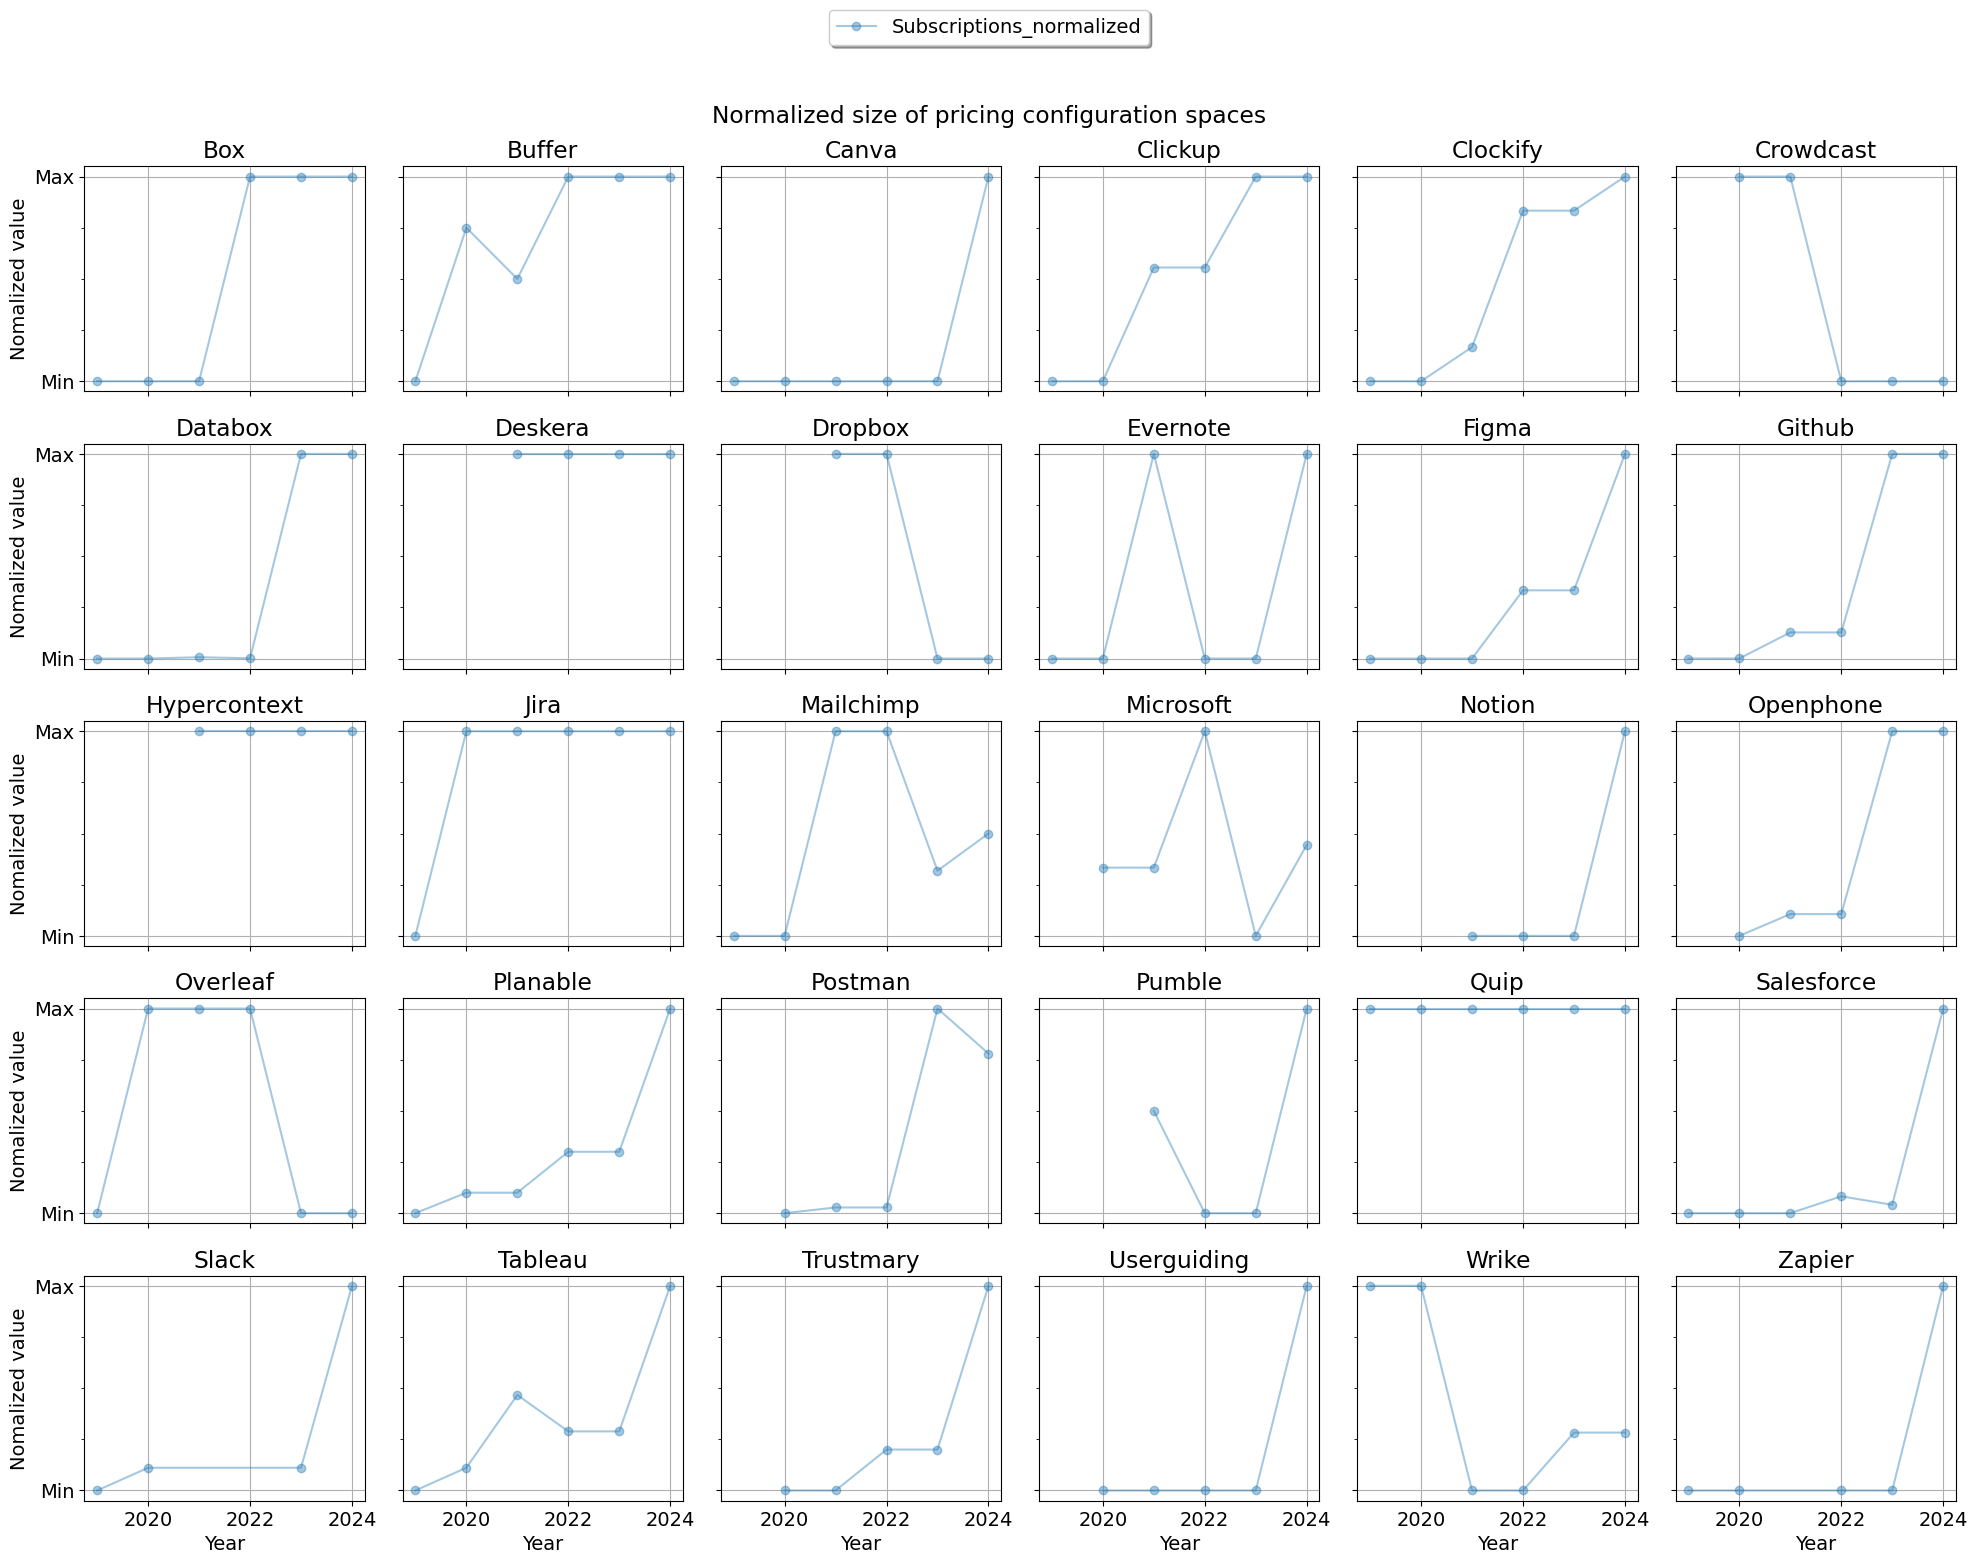

In [80]:
# Setting up the subplots as a 5x6 grid
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotting the data
saas_companies = subscriptions_df['Saas'].unique()
for i, saas in enumerate(saas_companies):
    df_saas = normalized_subscriptions_df[normalized_subscriptions_df['Saas'] == saas]
    # df_saas_features = df_normalized_features[df_normalized_features['Saas'] == saas]
    # df_saas_addons = df_normalized[df_normalized['Saas'] == saas]
    ax = axes[i]
    df_saas.plot(x='Year', y='Subscriptions_normalized', ax=ax, marker='o', alpha=0.4)
    # df_saas_features.plot(x='Year', y='Features_normalized', ax=ax, marker='o', alpha=0.4)
    # df_saas_addons.plot(x='Year', y='Addons_normalized', ax=ax, marker='o', alpha=0.4)
    ax.set_title(f'{saas}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Nomalized value')
    #ax.legend(['Plans Normalized', 'Features Normalized', 'Addons Normalized'])
    ax.grid(True)
    ax.get_legend().remove()  # Remove legend from subplots

    # Customizing the x-axis labels to show 'min' and 'max'
    min_label = "Min" #f"Min: P({df_saas['Plans_min'].iloc[0]}), F({df_saas['Features_min'].iloc[0]}), A({df_saas['Addons_min'].iloc[0]})"
    max_label = "Max" #f"Max: P({df_saas['Plans_max'].iloc[0]}), F({df_saas['Features_max'].iloc[0]}), A({df_saas['Addons_max'].iloc[0]})"
    ax.set_yticks([0, 1])
    ax.set_yticklabels([min_label, max_label])

# Remove any empty subplots
#for j in range(i+1, len(axes)):
#    fig.delaxes(axes[j])

# Add a single legend at the top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True)
fig.suptitle('Normalized size of pricing configuration spaces')

plt.tight_layout(rect=[0, 0, 1, 0.999])  # Adjust layout to make space for the legend
plt.tight_layout()
plt.show()

# Statistical tests

We compare if there are significant differences in the numer of features, plans and addons in the whole set of SaaS among the extreme years of the study (2019 and 2024).



In [81]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene

# Filter data for 2019 and 2024
df_2019 = df[df['Year'] == 2019]
df_2024 = df[df['Year'] == 2024]

# Compare Features
features_2019 = df_2019['Features'].dropna()
features_2024 = df_2024['Features'].dropna()

# Normality Test:
normal_features_2019 = shapiro(features_2019).pvalue > 0.05
normal_features_2024 = shapiro(features_2024).pvalue > 0.05

# Homoscedasticity (Variance homogeneity) test:
equal_var_features = levene(features_2019, features_2024).pvalue > 0.05

# T Student or Mann-Withney U tests:
if normal_features_2019 and normal_features_2024 and equal_var_features:
    features_stat, features_pvalue = ttest_ind(features_2019, features_2024)
else:
    features_stat, features_pvalue = mannwhitneyu(features_2019, features_2024)

# Compare Plans
plans_2019 = df_2019['Plans'].dropna()
plans_2024 = df_2024['Plans'].dropna()

# Normality Test:
normal_plans_2019 = shapiro(plans_2019).pvalue > 0.05
normal_plans_2024 = shapiro(plans_2024).pvalue > 0.05

# Homoscedasticity (Variance homogeneity) test:
equal_var_plans = levene(plans_2019, plans_2024).pvalue > 0.05

# T Student or Mann-Withney U tests:
if normal_plans_2019 and normal_plans_2024 and equal_var_plans:
    plans_stat, plans_pvalue = ttest_ind(plans_2019, plans_2024)
else:
    plans_stat, plans_pvalue = mannwhitneyu(plans_2019, plans_2024)

# Compare addons 
addons_2019 = df_2019['Addons'].dropna()
addons_2024 = df_2024['Addons'].dropna()

# Normality Test:
normal_addons_2019 = shapiro(addons_2019).pvalue > 0.05
normal_addons_2024 = shapiro(addons_2024).pvalue > 0.05

# Homoscedasticity (Variance homogeneity) test:
equal_var_addons = levene(addons_2019, addons_2024).pvalue > 0.05

# T Student or Mann-Withney U tests:
if normal_addons_2019 and normal_addons_2024 and equal_var_addons:
    addons_stat, addons_pvalue = ttest_ind(addons_2019, addons_2024)
else:
    addons_stat, addons_pvalue = mannwhitneyu(addons_2019, addons_2024)

(features_stat, features_pvalue), (plans_stat, plans_pvalue), (addons_stat, addons_pvalue)

((np.float64(85.5), np.float64(4.416418541032578e-05)),
 (np.float64(207.5), np.float64(0.08174306210097317)),
 (np.float64(150.5), np.float64(0.0025623599959758033)))

This code compares the features, plans and add-ons between 2019 and 2024 to see if there are statistically significant differences using the appropriate test depending on normality and homogeneity of variances.

**All the tests has shown statistically significant differences** (all p-values are <0.05), and differences between years 2019 and 2024 in addons and features were very strongly significant.

Next we compute effect size estimators. To calculate the effect size of the differences between 2019 and 2024, we can use Cohen's d for the Student's t-test (data following a normal distribution with homogeneous variance) and the r statistic for the Mann-Whitney U test (data that does not follow a normal distribution or with heterogeneous variance).

In [82]:
# Function for computing Cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.var(x) + (ny - 1) * np.var(y)) / dof)

if normal_features_2019 and normal_features_2024 and equal_var_features: 
    features_effect_size = cohen_d(features_2019, features_2024)
    features_estimator = "Cohen' s d:"
else:    
    features_effect_size = features_stat / np.sqrt(len(features_2019) * len(features_2024))
    features_estimator = "r:"

if normal_plans_2019 and normal_plans_2024 and equal_var_plans:    
    plans_effect_size = cohen_d(plans_2019, plans_2024)
    plans_estimator = "Cohen' s d:"
else:    
    plans_effect_size = plans_stat / np.sqrt(len(plans_2019) * len(plans_2024))
    plans_estimator = "r:"

if normal_addons_2019 and normal_addons_2024 and equal_var_addons:
    addons_effect_size = cohen_d(addons_2019, addons_2024)
    addons_estimator = "Cohen' s d :"
else:    
    addons_effect_size = addons_stat / np.sqrt(len(addons_2019) * len(addons_2024))
    addons_estimator = "r:"

('Features',features_estimator,features_effect_size), ('Plans',plans_estimator, plans_effect_size), ('Addons',addons_estimator, addons_effect_size)

(('Features', 'r:', np.float64(3.581200915893996)),
 ('Plans', 'r:', np.float64(8.69121859705268)),
 ('Addons', 'r:', np.float64(6.303751319790017)))

In [83]:
(equal_var_features,normal_features_2019,normal_features_2024),(equal_var_plans,normal_plans_2019,normal_plans_2024),(equal_var_addons,normal_addons_2019,normal_addons_2024)

((np.False_, np.True_, np.True_),
 (np.True_, np.False_, np.False_),
 (np.False_, np.False_, np.False_))


The effect size values computed in the analysis provide a measure of the magnitude of the differences between the two groups (2019 and 2024) for features, plans, and addons. Here is how to interpret these values:

#### Cohen's d (for t-tests)

Cohen's d is used to measure the effect size for t-tests. The interpretation of Cohen's d values is as follows:

* 0.2: Small effect size
* 0.5: Medium effect size
* 0.8: Large effect size
* A larger Cohen's d indicates a greater difference between the means of the two groups.

#### r (for Mann-Whitney U tests)
The effect size r for the Mann-Whitney U test is interpreted similarly to correlation coefficients:

* 0.1: Small effect size
* 0.3: Medium effect size
* 0.5: Large effect size
* A larger r indicates a greater difference between the distributions of the two groups.

### Practical Interpretation
**Features Effect Size:**

Since the effect size is around 0.3 (r estimator is used), the difference is moderate.


**Plans Effect Size:**

Since the effect size is above 0.5 (r estimator is used), the difference is large.

**Addons Effect Size:**

Since the effect size is above 0.5 (r estimator is used), the difference is large.


These effect sizes help us understand not just whether there is a statistically significant difference, but also the practical significance of the difference. A statistically significant result with a small effect size may indicate that while the difference is real, it is not very impactful in practical terms. Conversely, a large effect size indicates a meaningful difference that could have strong practical implications.